# Preface
**In this notebook we would be looking at fine tuning an [EfficientNet model](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html). EfficientNets are the class of models that work on computer vision tasks and have been implemented by Google. These models achieve state-of-art performance on computer vision tasks. Hence I decided to use it as the pretrained model for this task.**

**This notebook contains only the training part of the model. The inference and ensemble tasks should be carried out in seperate notebooks to iterate faster.**

**You could also look over my [ensemble notebook](https://www.kaggle.com/forwet/lyft-ensemble-and-submission) for a structured way to perform ensembling.**
 

**Version 2 Updates:**
1. raster_size - 300
2. max_num_steps - 500
3. train_batch_size - 12
4. train_num_workers - 4
5. model_save - On minimum training loss + At final iteration
6. WEIGHT_FILE - None


**Version 3 Updates**
1. pixel_size = 0.45
2. raster_size = 222 (calculated using pixel size)
3. epochs = 5
4. used [catalyst module](https://catalyst-team.github.io/catalyst/) for training of the model
5. trained the model on a subset of `12000` samples of the original dataset.
6. Validated the model on a subset of `500` samples.
7. Used function to get image size based on pixel size.

In [3]:
# Declaring the path to load efficientNet models.
import sys
sys.path.append('../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master')

In [4]:
#IMPORTS

# PyTorch
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50

# L5kit
from l5kit.configs import load_config_data
from l5kit.geometry import transform_points
from l5kit.rasterization import build_rasterizer
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset

# EfficientNet 
from efficientnet_pytorch import model as enet

# Catalyst module
from catalyst import dl
from catalyst.utils import metrics
from catalyst.dl import utils

# Miscellaneous
import os
import gc
import sys
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import Dict
import matplotlib.pyplot as plt
from tempfile import gettempdir
from prettytable import PrettyTable

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


# Configrations

In [5]:
# L5KIT'S CONFIGRATIONS

os.environ["L5KIT_DATA_FOLDER"] = "../input/lyft-motion-prediction-autonomous-vehicles"
dm = LocalDataManager()
cfg = {
        'model_params': {'model_architecture': 'efficientnet-b6',
          'history_num_frames': 0,
          'history_step_size': 1,
          'history_delta_time': 0.1,
          'future_num_frames': 50,
          'future_step_size': 1,
          'future_delta_time': 0.1},

        'raster_params': {'raster_size': [300, 300],
          'pixel_size': [0.33, 0.33],
          'ego_center': [0.25, 0.5],
          'map_type': 'py_semantic',
          'satellite_map_key': 'aerial_map/aerial_map.png',
          'semantic_map_key': 'semantic_map/semantic_map.pb',
          'dataset_meta_key': 'meta.json',
          'filter_agents_threshold': 0.5},

        'train_data_loader': {'key': 'scenes/train.zarr',
          'batch_size': 12,
          'shuffle': True,
          'num_workers': 4},

        "valid_data_loader":{"key": "scenes/validation.zarr",
                            "batch_size": 8,
                            "shuffle": False,
                            "num_workers": 4},
    
        }

**Using Peter's great explanation of `raster size` and `pixel size`, I built up a function to
calculate the `raster size` parameter from the given `pixel size`. Using the same values of velocity and time as Peter used in his explanation.**

In [6]:
def calc_img_size(px_size):
    return int(100/px_size)

In [7]:
# CONFIGRATIONS

WEIGHT_FILE = None # Model state_dict path of previously trained model
MODEL_NAME = "efficientnet-b0"
IMG_SIZE = calc_img_size(cfg["raster_params"]["pixel_size"][0])
VALIDATION = True # A hyperparameter you could use to toggle for validating the model

cfg["raster_params"]["raster_size"] = [IMG_SIZE, IMG_SIZE]

MODEL_NAME: It could be one of-
- "efficientnet-b0"
- "efficientnet-b1"
- "efficientnet-b2" 
- "efficientnet-b3"
- "efficientnet-b4" 
- "efficientnet-b5" 
- "efficientnet-b6"
- "efficientnet-b7" (Would likely to cause OOM due to larger architecture.)

IMG_SIZE: You can take either one of the following settings or try some other combinations-
- 300 (pixel size = 0.33)
- 224 (pixel size = 0.45)
- 267 (pixel size = 0.38)
- 245 (pixel size = 0.41)

**More info over `raster_size` and `pixel_size` can be found out [here](https://www.kaggle.com/c/lyft-motion-prediction-autonomous-vehicles/discussion/178323).** 

# Utility Scripts

In [66]:
%time
def build_model(cfg) -> torch.nn.Module:
    """Creates an instance of the pretrained model with custom input and output"""
    model = enet.EfficientNet.from_name(MODEL_NAME)
    
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    num_targets = 2*cfg["model_params"]["future_num_frames"]
    
    model._conv_stem = nn.Conv2d(
        num_in_channels,
        model._conv_stem.out_channels,
        kernel_size=model._conv_stem.kernel_size,
        stride=model._conv_stem.stride,
        padding=model._conv_stem.padding,
        bias=False
    )
    
    model._fc = nn.Linear(in_features=model._fc.in_features, out_features=num_targets)
    return model

def forward(data, model, device, criterion):
    """Forward Propogation function"""
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    
    outputs = model(inputs)
    outputs = outputs.reshape(targets.shape)
    loss = criterion(outputs, targets)
    
    loss = loss * target_availabilities
    loss = loss.mean()

    # Disabling rmse loss pertaining the mse loss.
    # loss = torch.sqrt(loss) # Using RMSE loss
    return loss, outputs


def get_dataloader(config, zarr_data, subset_len, map_type="py_semantic"):
    """Creates DataLoader instance for the given dataset."""
    cfg["raster_params"]["map_type"] = map_type
    rasterizer = build_rasterizer(cfg, dm)
    chunk_data = ChunkedDataset(zarr_data).open()
    agent_data = AgentDataset(cfg, chunk_data, rasterizer)
    
    # Sample the dataset
    subset_data = torch.utils.data.Subset(agent_data, range(0, subset_len))
    
    dataloader = DataLoader(subset_data, 
                            batch_size=config["batch_size"],
                            num_workers=config["num_workers"],
                            shuffle=config["shuffle"]
                           )
    return dataloader

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


In [ ]:
%time
def train(opt=None, criterion=None, lrate=1e-2):
        """Function for training the model"""
        print("Building Model...")
        device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = build_model(cfg).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lrate) if opt is None else opt
        criterion = nn.MSELoss(reduction="none")
        
        if WEIGHT_FILE is not None:
            state_dict = torch.load(WEIGHT_FILE, map_location=device)
            model.load_state_dict(state_dict)
        
        print("Prepairing Dataloader...")
        train_dataloader = get_dataloader(cfg["train_data_loader"], dm.require("scenes/train.zarr"), 12000)
        
        if VALIDATION:
            valid_dataloader = get_dataloader(cfg["valid_data_loader"], dm.require("scenes/validate.zarr"), 500)
            
        print("Training...")
        loaders = {
                    "train": train_dataloader,
                    "valid": valid_dataloader
                }

        device = utils.get_device()
        runner = LyftRunner(device=device)
        
        runner.train(
                model=model,
                optimizer=optimizer,
                loaders=loaders,
                logdir="./logs",
                num_epochs=5,
                verbose=True,
                load_best_on_end=True
            )
        return model

class LyftRunner(dl.Runner):

    def predict_batch(self, batch):
        return self.model(batch[0].to(self.device).view(batch[0].size(0), -1))

    def _handle_batch(self, batch):
        x, y = batch['image'], batch['target_positions']
        y_hat = self.model(x).reshape(y.shape)
        target_availabilities = batch["target_availabilities"].unsqueeze(-1)
        criterion = torch.nn.MSELoss(reduction="none")
        loss = criterion(y_hat, y)
        loss = loss * target_availabilities
        loss = loss.mean()
        self.batch_metrics.update(
            {"loss": loss}
        )

        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

# Visualizing images

**Let's just have a look at how the image would be formed using the current settings for `raster_size` and `pixel_size`.**
> The more you decrease the `pixel_size`, the more the image will be zoomed-in. 

In [ ]:
# Testing pixel_size and raster_size START 

In [8]:
# Preparing the EgoDataset from sample zarr file.
sample_zarr = dm.require("scenes/sample.zarr")
sample_chunk = ChunkedDataset(sample_zarr).open()
rasterizer = build_rasterizer(cfg, dm)
sample_ego = EgoDataset(cfg, sample_chunk, rasterizer)

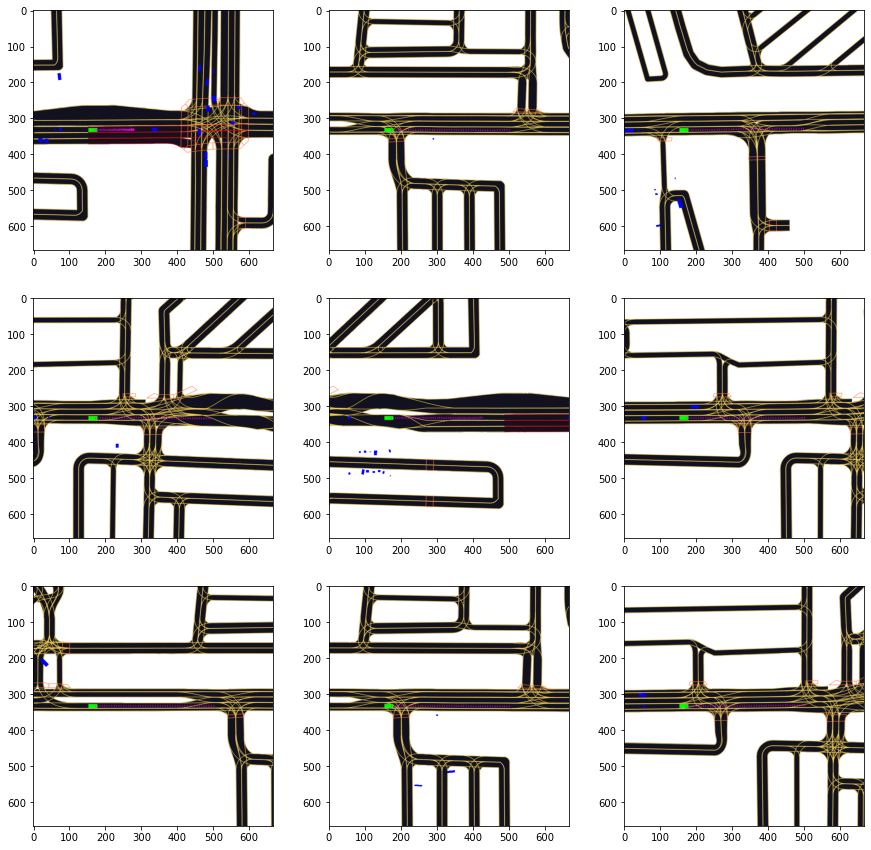

In [51]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
ax = ax.flatten()
for i in range(9):
    idx = np.random.randint(500)
    data = sample_ego[idx]
    im = data["image"].transpose(1, 2, 0)
    im = sample_ego.rasterizer.to_rgb(im)
    data_positions = transform_points(data["target_positions"]+data["centroid"], data["world_to_image"])
    draw_trajectory(im, data_positions, data["target_yaws"], TARGET_POINTS_COLOR)
    ax[i].imshow(im[::-1])
plt.show()

In [ ]:
# Testing END

# Train the model

In [67]:
# Use the above defined utility script to train the model.
model = train()

Building Model...
Prepairing Dataloader...
Training...

1/5 * Epoch (train):   0% 0/1000 [00:00<?, ?it/s]
1/5 * Epoch (train):   0% 0/1000 [00:03<?, ?it/s, loss=21.922]
1/5 * Epoch (train):   0% 1/1000 [00:03<1:06:13,  3.98s/it, loss=21.922]
1/5 * Epoch (train):   0% 1/1000 [00:04<1:06:13,  3.98s/it, loss=25.904]
1/5 * Epoch (train):   0% 2/1000 [00:04<49:34,  2.98s/it, loss=25.904]  
1/5 * Epoch (train):   0% 2/1000 [00:05<49:34,  2.98s/it, loss=2.638] 
1/5 * Epoch (train):   0% 3/1000 [00:05<37:29,  2.26s/it, loss=2.638]
1/5 * Epoch (train):   0% 3/1000 [00:06<37:29,  2.26s/it, loss=12.802]
1/5 * Epoch (train):   0% 4/1000 [00:06<30:51,  1.86s/it, loss=12.802]
1/5 * Epoch (train):   0% 4/1000 [00:06<30:51,  1.86s/it, loss=10.757]
1/5 * Epoch (train):   0% 5/1000 [00:06<25:46,  1.55s/it, loss=10.757]
1/5 * Epoch (train):   0% 5/1000 [00:07<25:46,  1.55s/it, loss=52.008]
1/5 * Epoch (train):   1% 6/1000 [00:07<20:37,  1.24s/it, loss=52.008]
1/5 * Epoch (train):   1% 6/1000 [00:08<20:37

1/5 * Epoch (train):   5% 54/1000 [00:42<10:52,  1.45it/s, loss=56.738]
1/5 * Epoch (train):   6% 55/1000 [00:42<10:09,  1.55it/s, loss=56.738]
1/5 * Epoch (train):   6% 55/1000 [00:43<10:09,  1.55it/s, loss=7.618] 
1/5 * Epoch (train):   6% 56/1000 [00:43<10:17,  1.53it/s, loss=7.618]
1/5 * Epoch (train):   6% 56/1000 [00:45<10:17,  1.53it/s, loss=21.250]
1/5 * Epoch (train):   6% 57/1000 [00:45<15:38,  1.00it/s, loss=21.250]
1/5 * Epoch (train):   6% 57/1000 [00:45<15:38,  1.00it/s, loss=48.559]
1/5 * Epoch (train):   6% 58/1000 [00:45<13:35,  1.15it/s, loss=48.559]
1/5 * Epoch (train):   6% 58/1000 [00:46<13:35,  1.15it/s, loss=9.440] 
1/5 * Epoch (train):   6% 59/1000 [00:46<11:53,  1.32it/s, loss=9.440]
1/5 * Epoch (train):   6% 59/1000 [00:46<11:53,  1.32it/s, loss=84.353]
1/5 * Epoch (train):   6% 60/1000 [00:46<10:36,  1.48it/s, loss=84.353]
1/5 * Epoch (train):   6% 60/1000 [00:47<10:36,  1.48it/s, loss=65.795]
1/5 * Epoch (train):   6% 61/1000 [00:47<13:14,  1.18it/s, loss=65

1/5 * Epoch (train):  11% 109/1000 [01:22<10:36,  1.40it/s, loss=20.712]
1/5 * Epoch (train):  11% 109/1000 [01:22<10:36,  1.40it/s, loss=10.553]
1/5 * Epoch (train):  11% 110/1000 [01:22<09:38,  1.54it/s, loss=10.553]
1/5 * Epoch (train):  11% 110/1000 [01:23<09:38,  1.54it/s, loss=1.865] 
1/5 * Epoch (train):  11% 111/1000 [01:23<09:08,  1.62it/s, loss=1.865]
1/5 * Epoch (train):  11% 111/1000 [01:23<09:08,  1.62it/s, loss=18.904]
1/5 * Epoch (train):  11% 112/1000 [01:23<08:47,  1.68it/s, loss=18.904]
1/5 * Epoch (train):  11% 112/1000 [01:24<08:47,  1.68it/s, loss=5.065] 
1/5 * Epoch (train):  11% 113/1000 [01:24<10:26,  1.42it/s, loss=5.065]
1/5 * Epoch (train):  11% 113/1000 [01:25<10:26,  1.42it/s, loss=27.092]
1/5 * Epoch (train):  11% 114/1000 [01:25<09:46,  1.51it/s, loss=27.092]
1/5 * Epoch (train):  11% 114/1000 [01:25<09:46,  1.51it/s, loss=15.465]
1/5 * Epoch (train):  12% 115/1000 [01:25<09:03,  1.63it/s, loss=15.465]
1/5 * Epoch (train):  12% 115/1000 [01:26<09:03,  1.6

1/5 * Epoch (train):  16% 163/1000 [01:59<09:34,  1.46it/s, loss=24.782]
1/5 * Epoch (train):  16% 163/1000 [02:00<09:34,  1.46it/s, loss=62.902]
1/5 * Epoch (train):  16% 164/1000 [02:00<08:59,  1.55it/s, loss=62.902]
1/5 * Epoch (train):  16% 164/1000 [02:01<08:59,  1.55it/s, loss=16.529]
1/5 * Epoch (train):  16% 165/1000 [02:01<12:44,  1.09it/s, loss=16.529]
1/5 * Epoch (train):  16% 165/1000 [02:02<12:44,  1.09it/s, loss=2.768] 
1/5 * Epoch (train):  17% 166/1000 [02:02<11:33,  1.20it/s, loss=2.768]
1/5 * Epoch (train):  17% 166/1000 [02:02<11:33,  1.20it/s, loss=37.356]
1/5 * Epoch (train):  17% 167/1000 [02:02<09:25,  1.47it/s, loss=37.356]
1/5 * Epoch (train):  17% 167/1000 [02:03<09:25,  1.47it/s, loss=39.953]
1/5 * Epoch (train):  17% 168/1000 [02:03<08:48,  1.57it/s, loss=39.953]
1/5 * Epoch (train):  17% 168/1000 [02:04<08:48,  1.57it/s, loss=40.354]
1/5 * Epoch (train):  17% 169/1000 [02:04<11:35,  1.20it/s, loss=40.354]
1/5 * Epoch (train):  17% 169/1000 [02:05<11:35,  1.

1/5 * Epoch (train):  22% 216/1000 [02:39<08:49,  1.48it/s, loss=11.190]
1/5 * Epoch (train):  22% 217/1000 [02:39<09:19,  1.40it/s, loss=11.190]
1/5 * Epoch (train):  22% 217/1000 [02:39<09:19,  1.40it/s, loss=32.888]
1/5 * Epoch (train):  22% 218/1000 [02:39<09:30,  1.37it/s, loss=32.888]
1/5 * Epoch (train):  22% 218/1000 [02:40<09:30,  1.37it/s, loss=1.507] 
1/5 * Epoch (train):  22% 219/1000 [02:40<09:09,  1.42it/s, loss=1.507]
1/5 * Epoch (train):  22% 219/1000 [02:41<09:09,  1.42it/s, loss=10.814]
1/5 * Epoch (train):  22% 220/1000 [02:41<08:58,  1.45it/s, loss=10.814]
1/5 * Epoch (train):  22% 220/1000 [02:42<08:58,  1.45it/s, loss=13.972]
1/5 * Epoch (train):  22% 221/1000 [02:42<09:39,  1.34it/s, loss=13.972]
1/5 * Epoch (train):  22% 221/1000 [02:42<09:39,  1.34it/s, loss=96.710]
1/5 * Epoch (train):  22% 222/1000 [02:42<08:31,  1.52it/s, loss=96.710]
1/5 * Epoch (train):  22% 222/1000 [02:43<08:31,  1.52it/s, loss=13.868]
1/5 * Epoch (train):  22% 223/1000 [02:43<08:30,  1.

1/5 * Epoch (train):  27% 270/1000 [03:17<08:41,  1.40it/s, loss=19.669]
1/5 * Epoch (train):  27% 270/1000 [03:17<08:41,  1.40it/s, loss=30.238]
1/5 * Epoch (train):  27% 271/1000 [03:17<08:08,  1.49it/s, loss=30.238]
1/5 * Epoch (train):  27% 271/1000 [03:18<08:08,  1.49it/s, loss=17.319]
1/5 * Epoch (train):  27% 272/1000 [03:18<09:10,  1.32it/s, loss=17.319]
1/5 * Epoch (train):  27% 272/1000 [03:19<09:10,  1.32it/s, loss=13.260]
1/5 * Epoch (train):  27% 273/1000 [03:19<08:34,  1.41it/s, loss=13.260]
1/5 * Epoch (train):  27% 273/1000 [03:19<08:34,  1.41it/s, loss=75.107]
1/5 * Epoch (train):  27% 274/1000 [03:19<08:17,  1.46it/s, loss=75.107]
1/5 * Epoch (train):  27% 274/1000 [03:20<08:17,  1.46it/s, loss=62.231]
1/5 * Epoch (train):  28% 275/1000 [03:20<08:23,  1.44it/s, loss=62.231]
1/5 * Epoch (train):  28% 275/1000 [03:21<08:23,  1.44it/s, loss=73.544]
1/5 * Epoch (train):  28% 276/1000 [03:21<07:55,  1.52it/s, loss=73.544]
1/5 * Epoch (train):  28% 276/1000 [03:21<07:55,  1

1/5 * Epoch (train):  32% 323/1000 [03:55<07:31,  1.50it/s, loss=22.362]
1/5 * Epoch (train):  32% 324/1000 [03:55<08:30,  1.32it/s, loss=22.362]
1/5 * Epoch (train):  32% 324/1000 [03:56<08:30,  1.32it/s, loss=15.107]
1/5 * Epoch (train):  32% 325/1000 [03:56<07:33,  1.49it/s, loss=15.107]
1/5 * Epoch (train):  32% 325/1000 [03:56<07:33,  1.49it/s, loss=21.655]
1/5 * Epoch (train):  33% 326/1000 [03:56<07:07,  1.58it/s, loss=21.655]
1/5 * Epoch (train):  33% 326/1000 [03:57<07:07,  1.58it/s, loss=38.411]
1/5 * Epoch (train):  33% 327/1000 [03:57<06:53,  1.63it/s, loss=38.411]
1/5 * Epoch (train):  33% 327/1000 [03:57<06:53,  1.63it/s, loss=42.574]
1/5 * Epoch (train):  33% 328/1000 [03:57<07:24,  1.51it/s, loss=42.574]
1/5 * Epoch (train):  33% 328/1000 [03:58<07:24,  1.51it/s, loss=11.699]
1/5 * Epoch (train):  33% 329/1000 [03:58<06:57,  1.61it/s, loss=11.699]
1/5 * Epoch (train):  33% 329/1000 [03:58<06:57,  1.61it/s, loss=26.724]
1/5 * Epoch (train):  33% 330/1000 [03:59<06:43,  1

1/5 * Epoch (train):  38% 377/1000 [04:33<07:13,  1.44it/s, loss=2.013]
1/5 * Epoch (train):  38% 377/1000 [04:34<07:13,  1.44it/s, loss=56.522]
1/5 * Epoch (train):  38% 378/1000 [04:34<08:21,  1.24it/s, loss=56.522]
1/5 * Epoch (train):  38% 378/1000 [04:35<08:21,  1.24it/s, loss=15.162]
1/5 * Epoch (train):  38% 379/1000 [04:35<07:28,  1.38it/s, loss=15.162]
1/5 * Epoch (train):  38% 379/1000 [04:36<07:28,  1.38it/s, loss=14.022]
1/5 * Epoch (train):  38% 380/1000 [04:36<07:10,  1.44it/s, loss=14.022]
1/5 * Epoch (train):  38% 380/1000 [04:36<07:10,  1.44it/s, loss=9.143] 
1/5 * Epoch (train):  38% 381/1000 [04:36<06:36,  1.56it/s, loss=9.143]
1/5 * Epoch (train):  38% 381/1000 [04:37<06:36,  1.56it/s, loss=4.981]
1/5 * Epoch (train):  38% 382/1000 [04:37<08:20,  1.23it/s, loss=4.981]
1/5 * Epoch (train):  38% 382/1000 [04:38<08:20,  1.23it/s, loss=53.644]
1/5 * Epoch (train):  38% 383/1000 [04:38<07:35,  1.35it/s, loss=53.644]
1/5 * Epoch (train):  38% 383/1000 [04:38<07:35,  1.35i

1/5 * Epoch (train):  43% 431/1000 [05:13<07:29,  1.26it/s, loss=18.299]
1/5 * Epoch (train):  43% 431/1000 [05:13<07:29,  1.26it/s, loss=15.662]
1/5 * Epoch (train):  43% 432/1000 [05:13<06:39,  1.42it/s, loss=15.662]
1/5 * Epoch (train):  43% 432/1000 [05:14<06:39,  1.42it/s, loss=86.978]
1/5 * Epoch (train):  43% 433/1000 [05:14<06:15,  1.51it/s, loss=86.978]
1/5 * Epoch (train):  43% 433/1000 [05:15<06:15,  1.51it/s, loss=29.017]
1/5 * Epoch (train):  43% 434/1000 [05:15<07:10,  1.31it/s, loss=29.017]
1/5 * Epoch (train):  43% 434/1000 [05:15<07:10,  1.31it/s, loss=18.679]
1/5 * Epoch (train):  44% 435/1000 [05:15<06:32,  1.44it/s, loss=18.679]
1/5 * Epoch (train):  44% 435/1000 [05:16<06:32,  1.44it/s, loss=21.134]
1/5 * Epoch (train):  44% 436/1000 [05:16<06:09,  1.53it/s, loss=21.134]
1/5 * Epoch (train):  44% 436/1000 [05:17<06:09,  1.53it/s, loss=28.967]
1/5 * Epoch (train):  44% 437/1000 [05:17<05:56,  1.58it/s, loss=28.967]
1/5 * Epoch (train):  44% 437/1000 [05:18<05:56,  1

1/5 * Epoch (train):  48% 485/1000 [05:51<05:58,  1.44it/s, loss=2.040]
1/5 * Epoch (train):  48% 485/1000 [05:52<05:58,  1.44it/s, loss=15.016]
1/5 * Epoch (train):  49% 486/1000 [05:52<07:58,  1.07it/s, loss=15.016]
1/5 * Epoch (train):  49% 486/1000 [05:53<07:58,  1.07it/s, loss=96.181]
1/5 * Epoch (train):  49% 487/1000 [05:53<06:54,  1.24it/s, loss=96.181]
1/5 * Epoch (train):  49% 487/1000 [05:53<06:54,  1.24it/s, loss=13.993]
1/5 * Epoch (train):  49% 488/1000 [05:53<06:14,  1.37it/s, loss=13.993]
1/5 * Epoch (train):  49% 488/1000 [05:54<06:14,  1.37it/s, loss=29.045]
1/5 * Epoch (train):  49% 489/1000 [05:54<05:39,  1.51it/s, loss=29.045]
1/5 * Epoch (train):  49% 489/1000 [05:55<05:39,  1.51it/s, loss=27.887]
1/5 * Epoch (train):  49% 490/1000 [05:55<07:05,  1.20it/s, loss=27.887]
1/5 * Epoch (train):  49% 490/1000 [05:55<07:05,  1.20it/s, loss=73.050]
1/5 * Epoch (train):  49% 491/1000 [05:56<06:28,  1.31it/s, loss=73.050]
1/5 * Epoch (train):  49% 491/1000 [05:56<06:28,  1.

1/5 * Epoch (train):  54% 539/1000 [06:30<04:46,  1.61it/s, loss=39.338]
1/5 * Epoch (train):  54% 539/1000 [06:30<04:46,  1.61it/s, loss=82.786]
1/5 * Epoch (train):  54% 540/1000 [06:30<04:25,  1.73it/s, loss=82.786]
1/5 * Epoch (train):  54% 540/1000 [06:31<04:25,  1.73it/s, loss=9.316] 
1/5 * Epoch (train):  54% 541/1000 [06:31<04:22,  1.75it/s, loss=9.316]
1/5 * Epoch (train):  54% 541/1000 [06:31<04:22,  1.75it/s, loss=14.231]
1/5 * Epoch (train):  54% 542/1000 [06:31<04:32,  1.68it/s, loss=14.231]
1/5 * Epoch (train):  54% 542/1000 [06:32<04:32,  1.68it/s, loss=3.230] 
1/5 * Epoch (train):  54% 543/1000 [06:32<04:27,  1.71it/s, loss=3.230]
1/5 * Epoch (train):  54% 543/1000 [06:32<04:27,  1.71it/s, loss=15.401]
1/5 * Epoch (train):  54% 544/1000 [06:32<04:27,  1.71it/s, loss=15.401]
1/5 * Epoch (train):  54% 544/1000 [06:33<04:27,  1.71it/s, loss=11.841]
1/5 * Epoch (train):  55% 545/1000 [06:33<04:41,  1.61it/s, loss=11.841]
1/5 * Epoch (train):  55% 545/1000 [06:34<04:41,  1.6

1/5 * Epoch (train):  59% 593/1000 [07:07<04:28,  1.52it/s, loss=39.755]
1/5 * Epoch (train):  59% 593/1000 [07:08<04:28,  1.52it/s, loss=0.631] 
1/5 * Epoch (train):  59% 594/1000 [07:08<05:07,  1.32it/s, loss=0.631]
1/5 * Epoch (train):  59% 594/1000 [07:08<05:07,  1.32it/s, loss=8.281]
1/5 * Epoch (train):  60% 595/1000 [07:08<04:47,  1.41it/s, loss=8.281]
1/5 * Epoch (train):  60% 595/1000 [07:09<04:47,  1.41it/s, loss=8.324]
1/5 * Epoch (train):  60% 596/1000 [07:09<04:34,  1.47it/s, loss=8.324]
1/5 * Epoch (train):  60% 596/1000 [07:10<04:34,  1.47it/s, loss=15.740]
1/5 * Epoch (train):  60% 597/1000 [07:10<04:18,  1.56it/s, loss=15.740]
1/5 * Epoch (train):  60% 597/1000 [07:11<04:18,  1.56it/s, loss=43.596]
1/5 * Epoch (train):  60% 598/1000 [07:11<06:55,  1.03s/it, loss=43.596]
1/5 * Epoch (train):  60% 598/1000 [07:12<06:55,  1.03s/it, loss=61.598]
1/5 * Epoch (train):  60% 599/1000 [07:12<06:02,  1.11it/s, loss=61.598]
1/5 * Epoch (train):  60% 599/1000 [07:13<06:02,  1.11it

1/5 * Epoch (train):  65% 647/1000 [07:45<04:22,  1.35it/s, loss=8.597]
1/5 * Epoch (train):  65% 647/1000 [07:46<04:22,  1.35it/s, loss=14.551]
1/5 * Epoch (train):  65% 648/1000 [07:46<04:03,  1.45it/s, loss=14.551]
1/5 * Epoch (train):  65% 648/1000 [07:46<04:03,  1.45it/s, loss=1.819] 
1/5 * Epoch (train):  65% 649/1000 [07:46<03:47,  1.54it/s, loss=1.819]
1/5 * Epoch (train):  65% 649/1000 [07:47<03:47,  1.54it/s, loss=4.726]
1/5 * Epoch (train):  65% 650/1000 [07:47<04:51,  1.20it/s, loss=4.726]
1/5 * Epoch (train):  65% 650/1000 [07:48<04:51,  1.20it/s, loss=1.630]
1/5 * Epoch (train):  65% 651/1000 [07:48<04:17,  1.35it/s, loss=1.630]
1/5 * Epoch (train):  65% 651/1000 [07:49<04:17,  1.35it/s, loss=14.568]
1/5 * Epoch (train):  65% 652/1000 [07:49<03:56,  1.47it/s, loss=14.568]
1/5 * Epoch (train):  65% 652/1000 [07:49<03:56,  1.47it/s, loss=9.480] 
1/5 * Epoch (train):  65% 653/1000 [07:49<03:38,  1.59it/s, loss=9.480]
1/5 * Epoch (train):  65% 653/1000 [07:50<03:38,  1.59it/s

1/5 * Epoch (train):  70% 701/1000 [08:24<03:02,  1.64it/s, loss=0.585]
1/5 * Epoch (train):  70% 701/1000 [08:25<03:02,  1.64it/s, loss=12.630]
1/5 * Epoch (train):  70% 702/1000 [08:25<04:12,  1.18it/s, loss=12.630]
1/5 * Epoch (train):  70% 702/1000 [08:26<04:12,  1.18it/s, loss=22.125]
1/5 * Epoch (train):  70% 703/1000 [08:26<03:45,  1.32it/s, loss=22.125]
1/5 * Epoch (train):  70% 703/1000 [08:27<03:45,  1.32it/s, loss=26.627]
1/5 * Epoch (train):  70% 704/1000 [08:27<03:31,  1.40it/s, loss=26.627]
1/5 * Epoch (train):  70% 704/1000 [08:27<03:31,  1.40it/s, loss=9.047] 
1/5 * Epoch (train):  70% 705/1000 [08:27<03:33,  1.38it/s, loss=9.047]
1/5 * Epoch (train):  70% 705/1000 [08:28<03:33,  1.38it/s, loss=15.391]
1/5 * Epoch (train):  71% 706/1000 [08:28<04:10,  1.18it/s, loss=15.391]
1/5 * Epoch (train):  71% 706/1000 [08:29<04:10,  1.18it/s, loss=65.073]
1/5 * Epoch (train):  71% 707/1000 [08:29<03:40,  1.33it/s, loss=65.073]
1/5 * Epoch (train):  71% 707/1000 [08:29<03:40,  1.3

1/5 * Epoch (train):  76% 755/1000 [09:03<03:16,  1.24it/s, loss=14.934]
1/5 * Epoch (train):  76% 755/1000 [09:03<03:16,  1.24it/s, loss=14.436]
1/5 * Epoch (train):  76% 756/1000 [09:03<02:45,  1.47it/s, loss=14.436]
1/5 * Epoch (train):  76% 756/1000 [09:04<02:45,  1.47it/s, loss=0.843] 
1/5 * Epoch (train):  76% 757/1000 [09:04<02:31,  1.60it/s, loss=0.843]
1/5 * Epoch (train):  76% 757/1000 [09:06<02:31,  1.60it/s, loss=40.239]
1/5 * Epoch (train):  76% 758/1000 [09:06<03:58,  1.01it/s, loss=40.239]
1/5 * Epoch (train):  76% 758/1000 [09:06<03:58,  1.01it/s, loss=12.474]
1/5 * Epoch (train):  76% 759/1000 [09:06<03:34,  1.12it/s, loss=12.474]
1/5 * Epoch (train):  76% 759/1000 [09:07<03:34,  1.12it/s, loss=1.478] 
1/5 * Epoch (train):  76% 760/1000 [09:07<03:12,  1.25it/s, loss=1.478]
1/5 * Epoch (train):  76% 760/1000 [09:07<03:12,  1.25it/s, loss=32.112]
1/5 * Epoch (train):  76% 761/1000 [09:07<02:47,  1.43it/s, loss=32.112]
1/5 * Epoch (train):  76% 761/1000 [09:09<02:47,  1.4

1/5 * Epoch (train):  81% 809/1000 [09:40<01:46,  1.79it/s, loss=32.369]
1/5 * Epoch (train):  81% 809/1000 [09:42<01:46,  1.79it/s, loss=32.876]
1/5 * Epoch (train):  81% 810/1000 [09:42<02:36,  1.21it/s, loss=32.876]
1/5 * Epoch (train):  81% 810/1000 [09:42<02:36,  1.21it/s, loss=31.108]
1/5 * Epoch (train):  81% 811/1000 [09:42<02:18,  1.36it/s, loss=31.108]
1/5 * Epoch (train):  81% 811/1000 [09:43<02:18,  1.36it/s, loss=25.902]
1/5 * Epoch (train):  81% 812/1000 [09:43<01:54,  1.64it/s, loss=25.902]
1/5 * Epoch (train):  81% 812/1000 [09:43<01:54,  1.64it/s, loss=65.846]
1/5 * Epoch (train):  81% 813/1000 [09:43<01:47,  1.73it/s, loss=65.846]
1/5 * Epoch (train):  81% 813/1000 [09:44<01:47,  1.73it/s, loss=26.664]
1/5 * Epoch (train):  81% 814/1000 [09:44<02:17,  1.36it/s, loss=26.664]
1/5 * Epoch (train):  81% 814/1000 [09:45<02:17,  1.36it/s, loss=10.712]
1/5 * Epoch (train):  82% 815/1000 [09:45<02:01,  1.52it/s, loss=10.712]
1/5 * Epoch (train):  82% 815/1000 [09:45<02:01,  1

1/5 * Epoch (train):  86% 863/1000 [10:20<01:33,  1.47it/s, loss=38.302]
1/5 * Epoch (train):  86% 863/1000 [10:20<01:33,  1.47it/s, loss=17.724]
1/5 * Epoch (train):  86% 864/1000 [10:20<01:27,  1.55it/s, loss=17.724]
1/5 * Epoch (train):  86% 864/1000 [10:21<01:27,  1.55it/s, loss=13.986]
1/5 * Epoch (train):  86% 865/1000 [10:21<01:22,  1.64it/s, loss=13.986]
1/5 * Epoch (train):  86% 865/1000 [10:22<01:22,  1.64it/s, loss=8.437] 
1/5 * Epoch (train):  87% 866/1000 [10:22<01:32,  1.45it/s, loss=8.437]
1/5 * Epoch (train):  87% 866/1000 [10:22<01:32,  1.45it/s, loss=3.257]
1/5 * Epoch (train):  87% 867/1000 [10:22<01:26,  1.54it/s, loss=3.257]
1/5 * Epoch (train):  87% 867/1000 [10:23<01:26,  1.54it/s, loss=64.403]
1/5 * Epoch (train):  87% 868/1000 [10:23<01:22,  1.60it/s, loss=64.403]
1/5 * Epoch (train):  87% 868/1000 [10:23<01:22,  1.60it/s, loss=5.337] 
1/5 * Epoch (train):  87% 869/1000 [10:23<01:21,  1.62it/s, loss=5.337]
1/5 * Epoch (train):  87% 869/1000 [10:24<01:21,  1.62i

1/5 * Epoch (train):  92% 917/1000 [10:55<00:59,  1.40it/s, loss=27.819]
1/5 * Epoch (train):  92% 917/1000 [10:56<00:59,  1.40it/s, loss=26.231]
1/5 * Epoch (train):  92% 918/1000 [10:56<00:53,  1.52it/s, loss=26.231]
1/5 * Epoch (train):  92% 918/1000 [10:56<00:53,  1.52it/s, loss=59.614]
1/5 * Epoch (train):  92% 919/1000 [10:56<00:50,  1.61it/s, loss=59.614]
1/5 * Epoch (train):  92% 919/1000 [10:57<00:50,  1.61it/s, loss=46.507]
1/5 * Epoch (train):  92% 920/1000 [10:57<00:47,  1.69it/s, loss=46.507]
1/5 * Epoch (train):  92% 920/1000 [10:58<00:47,  1.69it/s, loss=54.490]
1/5 * Epoch (train):  92% 921/1000 [10:58<00:58,  1.35it/s, loss=54.490]
1/5 * Epoch (train):  92% 921/1000 [10:59<00:58,  1.35it/s, loss=2.033] 
1/5 * Epoch (train):  92% 922/1000 [10:59<00:51,  1.50it/s, loss=2.033]
1/5 * Epoch (train):  92% 922/1000 [10:59<00:51,  1.50it/s, loss=0.173]
1/5 * Epoch (train):  92% 923/1000 [10:59<00:49,  1.56it/s, loss=0.173]
1/5 * Epoch (train):  92% 923/1000 [11:00<00:49,  1.56

1/5 * Epoch (train):  97% 971/1000 [11:33<00:18,  1.55it/s, loss=25.879]
1/5 * Epoch (train):  97% 971/1000 [11:34<00:18,  1.55it/s, loss=15.971]
1/5 * Epoch (train):  97% 972/1000 [11:34<00:22,  1.26it/s, loss=15.971]
1/5 * Epoch (train):  97% 972/1000 [11:35<00:22,  1.26it/s, loss=11.247]
1/5 * Epoch (train):  97% 973/1000 [11:35<00:19,  1.42it/s, loss=11.247]
1/5 * Epoch (train):  97% 973/1000 [11:35<00:19,  1.42it/s, loss=40.126]
1/5 * Epoch (train):  97% 974/1000 [11:35<00:17,  1.50it/s, loss=40.126]
1/5 * Epoch (train):  97% 974/1000 [11:36<00:17,  1.50it/s, loss=22.818]
1/5 * Epoch (train):  98% 975/1000 [11:36<00:17,  1.44it/s, loss=22.818]
1/5 * Epoch (train):  98% 975/1000 [11:37<00:17,  1.44it/s, loss=26.911]
1/5 * Epoch (train):  98% 976/1000 [11:37<00:18,  1.28it/s, loss=26.911]
1/5 * Epoch (train):  98% 976/1000 [11:37<00:18,  1.28it/s, loss=17.210]
1/5 * Epoch (train):  98% 977/1000 [11:37<00:15,  1.44it/s, loss=17.210]
1/5 * Epoch (train):  98% 977/1000 [11:38<00:15,  1

1/5 * Epoch (valid):  40% 25/63 [00:11<00:17,  2.21it/s, loss=0.202]
1/5 * Epoch (valid):  41% 26/63 [00:11<00:13,  2.65it/s, loss=0.202]
1/5 * Epoch (valid):  41% 26/63 [00:11<00:13,  2.65it/s, loss=0.194]
1/5 * Epoch (valid):  43% 27/63 [00:11<00:11,  3.20it/s, loss=0.194]
1/5 * Epoch (valid):  43% 27/63 [00:11<00:11,  3.20it/s, loss=0.223]
1/5 * Epoch (valid):  44% 28/63 [00:11<00:09,  3.58it/s, loss=0.223]
1/5 * Epoch (valid):  44% 28/63 [00:12<00:09,  3.58it/s, loss=0.206]
1/5 * Epoch (valid):  46% 29/63 [00:12<00:15,  2.16it/s, loss=0.206]
1/5 * Epoch (valid):  46% 29/63 [00:12<00:15,  2.16it/s, loss=0.243]
1/5 * Epoch (valid):  48% 30/63 [00:12<00:13,  2.37it/s, loss=0.243]
1/5 * Epoch (valid):  48% 30/63 [00:12<00:13,  2.37it/s, loss=0.238]
1/5 * Epoch (valid):  49% 31/63 [00:12<00:11,  2.86it/s, loss=0.238]
1/5 * Epoch (valid):  49% 31/63 [00:12<00:11,  2.86it/s, loss=11.683]
1/5 * Epoch (valid):  51% 32/63 [00:13<00:09,  3.23it/s, loss=11.683]
1/5 * Epoch (valid):  51% 32/63 

2/5 * Epoch (train):   2% 17/1000 [00:14<10:54,  1.50it/s, loss=23.780]
2/5 * Epoch (train):   2% 17/1000 [00:14<10:54,  1.50it/s, loss=42.425]
2/5 * Epoch (train):   2% 18/1000 [00:14<10:27,  1.56it/s, loss=42.425]
2/5 * Epoch (train):   2% 18/1000 [00:15<10:27,  1.56it/s, loss=23.113]
2/5 * Epoch (train):   2% 19/1000 [00:15<10:30,  1.55it/s, loss=23.113]
2/5 * Epoch (train):   2% 19/1000 [00:15<10:30,  1.55it/s, loss=6.094] 
2/5 * Epoch (train):   2% 20/1000 [00:15<10:04,  1.62it/s, loss=6.094]
2/5 * Epoch (train):   2% 20/1000 [00:17<10:04,  1.62it/s, loss=4.187]
2/5 * Epoch (train):   2% 21/1000 [00:17<12:57,  1.26it/s, loss=4.187]
2/5 * Epoch (train):   2% 21/1000 [00:17<12:57,  1.26it/s, loss=4.823]
2/5 * Epoch (train):   2% 22/1000 [00:17<11:39,  1.40it/s, loss=4.823]
2/5 * Epoch (train):   2% 22/1000 [00:18<11:39,  1.40it/s, loss=2.634]
2/5 * Epoch (train):   2% 23/1000 [00:18<10:36,  1.53it/s, loss=2.634]
2/5 * Epoch (train):   2% 23/1000 [00:18<10:36,  1.53it/s, loss=19.739]

2/5 * Epoch (train):   7% 71/1000 [00:51<10:51,  1.43it/s, loss=2.323] 
2/5 * Epoch (train):   7% 72/1000 [00:51<10:03,  1.54it/s, loss=2.323]
2/5 * Epoch (train):   7% 72/1000 [00:52<10:03,  1.54it/s, loss=124.017]
2/5 * Epoch (train):   7% 73/1000 [00:52<11:13,  1.38it/s, loss=124.017]
2/5 * Epoch (train):   7% 73/1000 [00:53<11:13,  1.38it/s, loss=28.171] 
2/5 * Epoch (train):   7% 74/1000 [00:53<11:52,  1.30it/s, loss=28.171]
2/5 * Epoch (train):   7% 74/1000 [00:54<11:52,  1.30it/s, loss=29.116]
2/5 * Epoch (train):   8% 75/1000 [00:54<11:22,  1.36it/s, loss=29.116]
2/5 * Epoch (train):   8% 75/1000 [00:54<11:22,  1.36it/s, loss=46.341]
2/5 * Epoch (train):   8% 76/1000 [00:55<10:34,  1.46it/s, loss=46.341]
2/5 * Epoch (train):   8% 76/1000 [00:56<10:34,  1.46it/s, loss=18.915]
2/5 * Epoch (train):   8% 77/1000 [00:56<13:08,  1.17it/s, loss=18.915]
2/5 * Epoch (train):   8% 77/1000 [00:56<13:08,  1.17it/s, loss=4.351] 
2/5 * Epoch (train):   8% 78/1000 [00:56<11:23,  1.35it/s, los

2/5 * Epoch (train):  12% 125/1000 [01:29<11:17,  1.29it/s, loss=30.029]
2/5 * Epoch (train):  13% 126/1000 [01:29<09:57,  1.46it/s, loss=30.029]
2/5 * Epoch (train):  13% 126/1000 [01:29<09:57,  1.46it/s, loss=2.539] 
2/5 * Epoch (train):  13% 127/1000 [01:29<09:04,  1.60it/s, loss=2.539]
2/5 * Epoch (train):  13% 127/1000 [01:30<09:04,  1.60it/s, loss=26.932]
2/5 * Epoch (train):  13% 128/1000 [01:30<08:22,  1.73it/s, loss=26.932]
2/5 * Epoch (train):  13% 128/1000 [01:31<08:22,  1.73it/s, loss=1.942] 
2/5 * Epoch (train):  13% 129/1000 [01:31<10:57,  1.32it/s, loss=1.942]
2/5 * Epoch (train):  13% 129/1000 [01:31<10:57,  1.32it/s, loss=8.896]
2/5 * Epoch (train):  13% 130/1000 [01:31<10:03,  1.44it/s, loss=8.896]
2/5 * Epoch (train):  13% 130/1000 [01:32<10:03,  1.44it/s, loss=75.251]
2/5 * Epoch (train):  13% 131/1000 [01:32<08:52,  1.63it/s, loss=75.251]
2/5 * Epoch (train):  13% 131/1000 [01:32<08:52,  1.63it/s, loss=26.580]
2/5 * Epoch (train):  13% 132/1000 [01:32<08:40,  1.67i

2/5 * Epoch (train):  18% 179/1000 [02:05<07:55,  1.72it/s, loss=13.714]
2/5 * Epoch (train):  18% 180/1000 [02:05<07:38,  1.79it/s, loss=13.714]
2/5 * Epoch (train):  18% 180/1000 [02:06<07:38,  1.79it/s, loss=39.816]
2/5 * Epoch (train):  18% 181/1000 [02:06<09:16,  1.47it/s, loss=39.816]
2/5 * Epoch (train):  18% 181/1000 [02:07<09:16,  1.47it/s, loss=4.072] 
2/5 * Epoch (train):  18% 182/1000 [02:07<08:28,  1.61it/s, loss=4.072]
2/5 * Epoch (train):  18% 182/1000 [02:07<08:28,  1.61it/s, loss=7.577]
2/5 * Epoch (train):  18% 183/1000 [02:07<07:39,  1.78it/s, loss=7.577]
2/5 * Epoch (train):  18% 183/1000 [02:08<07:39,  1.78it/s, loss=22.773]
2/5 * Epoch (train):  18% 184/1000 [02:08<07:12,  1.89it/s, loss=22.773]
2/5 * Epoch (train):  18% 184/1000 [02:09<07:12,  1.89it/s, loss=61.215]
2/5 * Epoch (train):  18% 185/1000 [02:09<09:10,  1.48it/s, loss=61.215]
2/5 * Epoch (train):  18% 185/1000 [02:09<09:10,  1.48it/s, loss=1.259] 
2/5 * Epoch (train):  19% 186/1000 [02:09<08:15,  1.64

2/5 * Epoch (train):  23% 233/1000 [02:42<08:16,  1.54it/s, loss=16.223]
2/5 * Epoch (train):  23% 234/1000 [02:42<07:39,  1.67it/s, loss=16.223]
2/5 * Epoch (train):  23% 234/1000 [02:42<07:39,  1.67it/s, loss=77.915]
2/5 * Epoch (train):  24% 235/1000 [02:42<07:36,  1.68it/s, loss=77.915]
2/5 * Epoch (train):  24% 235/1000 [02:43<07:36,  1.68it/s, loss=44.838]
2/5 * Epoch (train):  24% 236/1000 [02:43<07:47,  1.63it/s, loss=44.838]
2/5 * Epoch (train):  24% 236/1000 [02:44<07:47,  1.63it/s, loss=1.496] 
2/5 * Epoch (train):  24% 237/1000 [02:44<10:50,  1.17it/s, loss=1.496]
2/5 * Epoch (train):  24% 237/1000 [02:45<10:50,  1.17it/s, loss=44.231]
2/5 * Epoch (train):  24% 238/1000 [02:45<09:33,  1.33it/s, loss=44.231]
2/5 * Epoch (train):  24% 238/1000 [02:45<09:33,  1.33it/s, loss=35.588]
2/5 * Epoch (train):  24% 239/1000 [02:45<08:34,  1.48it/s, loss=35.588]
2/5 * Epoch (train):  24% 239/1000 [02:46<08:34,  1.48it/s, loss=12.782]
2/5 * Epoch (train):  24% 240/1000 [02:46<07:46,  1.

2/5 * Epoch (train):  29% 287/1000 [03:19<07:19,  1.62it/s, loss=27.007]
2/5 * Epoch (train):  29% 288/1000 [03:19<07:09,  1.66it/s, loss=27.007]
2/5 * Epoch (train):  29% 288/1000 [03:21<07:09,  1.66it/s, loss=0.668] 
2/5 * Epoch (train):  29% 289/1000 [03:21<09:06,  1.30it/s, loss=0.668]
2/5 * Epoch (train):  29% 289/1000 [03:21<09:06,  1.30it/s, loss=57.622]
2/5 * Epoch (train):  29% 290/1000 [03:21<08:04,  1.47it/s, loss=57.622]
2/5 * Epoch (train):  29% 290/1000 [03:21<08:04,  1.47it/s, loss=1.140] 
2/5 * Epoch (train):  29% 291/1000 [03:22<07:13,  1.63it/s, loss=1.140]
2/5 * Epoch (train):  29% 291/1000 [03:22<07:13,  1.63it/s, loss=21.624]
2/5 * Epoch (train):  29% 292/1000 [03:22<06:53,  1.71it/s, loss=21.624]
2/5 * Epoch (train):  29% 292/1000 [03:23<06:53,  1.71it/s, loss=44.262]
2/5 * Epoch (train):  29% 293/1000 [03:23<08:59,  1.31it/s, loss=44.262]
2/5 * Epoch (train):  29% 293/1000 [03:24<08:59,  1.31it/s, loss=39.670]
2/5 * Epoch (train):  29% 294/1000 [03:24<08:09,  1.4

2/5 * Epoch (train):  34% 341/1000 [03:56<07:23,  1.48it/s, loss=0.697] 
2/5 * Epoch (train):  34% 342/1000 [03:56<08:05,  1.36it/s, loss=0.697]
2/5 * Epoch (train):  34% 342/1000 [03:57<08:05,  1.36it/s, loss=15.867]
2/5 * Epoch (train):  34% 343/1000 [03:57<07:25,  1.48it/s, loss=15.867]
2/5 * Epoch (train):  34% 343/1000 [03:57<07:25,  1.48it/s, loss=33.261]
2/5 * Epoch (train):  34% 344/1000 [03:57<06:52,  1.59it/s, loss=33.261]
2/5 * Epoch (train):  34% 344/1000 [03:58<06:52,  1.59it/s, loss=31.483]
2/5 * Epoch (train):  34% 345/1000 [03:58<07:30,  1.45it/s, loss=31.483]
2/5 * Epoch (train):  34% 345/1000 [03:59<07:30,  1.45it/s, loss=28.840]
2/5 * Epoch (train):  35% 346/1000 [03:59<08:41,  1.25it/s, loss=28.840]
2/5 * Epoch (train):  35% 346/1000 [04:00<08:41,  1.25it/s, loss=37.096]
2/5 * Epoch (train):  35% 347/1000 [04:00<07:46,  1.40it/s, loss=37.096]
2/5 * Epoch (train):  35% 347/1000 [04:00<07:46,  1.40it/s, loss=5.105] 
2/5 * Epoch (train):  35% 348/1000 [04:00<07:31,  1.

2/5 * Epoch (train):  40% 395/1000 [04:32<05:43,  1.76it/s, loss=16.887]
2/5 * Epoch (train):  40% 396/1000 [04:32<05:09,  1.95it/s, loss=16.887]
2/5 * Epoch (train):  40% 396/1000 [04:33<05:09,  1.95it/s, loss=4.735] 
2/5 * Epoch (train):  40% 397/1000 [04:33<07:08,  1.41it/s, loss=4.735]
2/5 * Epoch (train):  40% 397/1000 [04:34<07:08,  1.41it/s, loss=37.263]
2/5 * Epoch (train):  40% 398/1000 [04:34<06:37,  1.51it/s, loss=37.263]
2/5 * Epoch (train):  40% 398/1000 [04:34<06:37,  1.51it/s, loss=8.581] 
2/5 * Epoch (train):  40% 399/1000 [04:34<06:08,  1.63it/s, loss=8.581]
2/5 * Epoch (train):  40% 399/1000 [04:35<06:08,  1.63it/s, loss=8.709]
2/5 * Epoch (train):  40% 400/1000 [04:35<05:44,  1.74it/s, loss=8.709]
2/5 * Epoch (train):  40% 400/1000 [04:36<05:44,  1.74it/s, loss=41.163]
2/5 * Epoch (train):  40% 401/1000 [04:36<07:20,  1.36it/s, loss=41.163]
2/5 * Epoch (train):  40% 401/1000 [04:37<07:20,  1.36it/s, loss=25.754]
2/5 * Epoch (train):  40% 402/1000 [04:37<06:46,  1.47i

2/5 * Epoch (train):  45% 449/1000 [05:09<05:51,  1.57it/s, loss=19.092]
2/5 * Epoch (train):  45% 450/1000 [05:09<07:02,  1.30it/s, loss=19.092]
2/5 * Epoch (train):  45% 450/1000 [05:10<07:02,  1.30it/s, loss=11.745]
2/5 * Epoch (train):  45% 451/1000 [05:10<06:13,  1.47it/s, loss=11.745]
2/5 * Epoch (train):  45% 451/1000 [05:10<06:13,  1.47it/s, loss=38.973]
2/5 * Epoch (train):  45% 452/1000 [05:10<05:33,  1.64it/s, loss=38.973]
2/5 * Epoch (train):  45% 452/1000 [05:11<05:33,  1.64it/s, loss=44.618]
2/5 * Epoch (train):  45% 453/1000 [05:11<05:20,  1.71it/s, loss=44.618]
2/5 * Epoch (train):  45% 453/1000 [05:12<05:20,  1.71it/s, loss=25.005]
2/5 * Epoch (train):  45% 454/1000 [05:12<06:12,  1.47it/s, loss=25.005]
2/5 * Epoch (train):  45% 454/1000 [05:12<06:12,  1.47it/s, loss=1.501] 
2/5 * Epoch (train):  46% 455/1000 [05:12<05:38,  1.61it/s, loss=1.501]
2/5 * Epoch (train):  46% 455/1000 [05:12<05:38,  1.61it/s, loss=28.281]
2/5 * Epoch (train):  46% 456/1000 [05:12<04:56,  1.

2/5 * Epoch (train):  50% 503/1000 [05:45<05:34,  1.49it/s, loss=6.479] 
2/5 * Epoch (train):  50% 504/1000 [05:45<05:07,  1.61it/s, loss=6.479]
2/5 * Epoch (train):  50% 504/1000 [05:45<05:07,  1.61it/s, loss=31.974]
2/5 * Epoch (train):  50% 505/1000 [05:45<05:04,  1.62it/s, loss=31.974]
2/5 * Epoch (train):  50% 505/1000 [05:46<05:04,  1.62it/s, loss=35.623]
2/5 * Epoch (train):  51% 506/1000 [05:46<06:20,  1.30it/s, loss=35.623]
2/5 * Epoch (train):  51% 506/1000 [05:47<06:20,  1.30it/s, loss=49.440]
2/5 * Epoch (train):  51% 507/1000 [05:47<05:38,  1.45it/s, loss=49.440]
2/5 * Epoch (train):  51% 507/1000 [05:47<05:38,  1.45it/s, loss=59.186]
2/5 * Epoch (train):  51% 508/1000 [05:47<05:36,  1.46it/s, loss=59.186]
2/5 * Epoch (train):  51% 508/1000 [05:48<05:36,  1.46it/s, loss=6.300] 
2/5 * Epoch (train):  51% 509/1000 [05:48<05:58,  1.37it/s, loss=6.300]
2/5 * Epoch (train):  51% 509/1000 [05:49<05:58,  1.37it/s, loss=1.247]
2/5 * Epoch (train):  51% 510/1000 [05:49<06:53,  1.19

2/5 * Epoch (train):  56% 557/1000 [06:20<04:22,  1.69it/s, loss=10.574]
2/5 * Epoch (train):  56% 558/1000 [06:20<04:18,  1.71it/s, loss=10.574]
2/5 * Epoch (train):  56% 558/1000 [06:21<04:18,  1.71it/s, loss=22.389]
2/5 * Epoch (train):  56% 559/1000 [06:21<04:32,  1.62it/s, loss=22.389]
2/5 * Epoch (train):  56% 559/1000 [06:22<04:32,  1.62it/s, loss=1.742] 
2/5 * Epoch (train):  56% 560/1000 [06:22<04:17,  1.71it/s, loss=1.742]
2/5 * Epoch (train):  56% 560/1000 [06:22<04:17,  1.71it/s, loss=15.420]
2/5 * Epoch (train):  56% 561/1000 [06:22<04:39,  1.57it/s, loss=15.420]
2/5 * Epoch (train):  56% 561/1000 [06:23<04:39,  1.57it/s, loss=15.989]
2/5 * Epoch (train):  56% 562/1000 [06:23<04:29,  1.63it/s, loss=15.989]
2/5 * Epoch (train):  56% 562/1000 [06:24<04:29,  1.63it/s, loss=40.700]
2/5 * Epoch (train):  56% 563/1000 [06:24<05:03,  1.44it/s, loss=40.700]
2/5 * Epoch (train):  56% 563/1000 [06:24<05:03,  1.44it/s, loss=30.270]
2/5 * Epoch (train):  56% 564/1000 [06:24<04:44,  1.

2/5 * Epoch (train):  61% 611/1000 [06:58<05:34,  1.16it/s, loss=15.712]
2/5 * Epoch (train):  61% 612/1000 [06:58<04:47,  1.35it/s, loss=15.712]
2/5 * Epoch (train):  61% 612/1000 [06:58<04:47,  1.35it/s, loss=3.165] 
2/5 * Epoch (train):  61% 613/1000 [06:58<04:34,  1.41it/s, loss=3.165]
2/5 * Epoch (train):  61% 613/1000 [06:59<04:34,  1.41it/s, loss=37.721]
2/5 * Epoch (train):  61% 614/1000 [06:59<04:10,  1.54it/s, loss=37.721]
2/5 * Epoch (train):  61% 614/1000 [07:00<04:10,  1.54it/s, loss=9.997] 
2/5 * Epoch (train):  62% 615/1000 [07:00<04:54,  1.31it/s, loss=9.997]
2/5 * Epoch (train):  62% 615/1000 [07:00<04:54,  1.31it/s, loss=14.723]
2/5 * Epoch (train):  62% 616/1000 [07:00<04:24,  1.45it/s, loss=14.723]
2/5 * Epoch (train):  62% 616/1000 [07:01<04:24,  1.45it/s, loss=2.033] 
2/5 * Epoch (train):  62% 617/1000 [07:01<04:05,  1.56it/s, loss=2.033]
2/5 * Epoch (train):  62% 617/1000 [07:01<04:05,  1.56it/s, loss=0.999]
2/5 * Epoch (train):  62% 618/1000 [07:01<03:52,  1.65i

2/5 * Epoch (train):  66% 665/1000 [07:33<03:40,  1.52it/s, loss=2.438] 
2/5 * Epoch (train):  67% 666/1000 [07:33<03:37,  1.54it/s, loss=2.438]
2/5 * Epoch (train):  67% 666/1000 [07:34<03:37,  1.54it/s, loss=29.895]
2/5 * Epoch (train):  67% 667/1000 [07:34<03:54,  1.42it/s, loss=29.895]
2/5 * Epoch (train):  67% 667/1000 [07:34<03:54,  1.42it/s, loss=4.952] 
2/5 * Epoch (train):  67% 668/1000 [07:34<03:29,  1.58it/s, loss=4.952]
2/5 * Epoch (train):  67% 668/1000 [07:35<03:29,  1.58it/s, loss=2.901]
2/5 * Epoch (train):  67% 669/1000 [07:35<03:13,  1.71it/s, loss=2.901]
2/5 * Epoch (train):  67% 669/1000 [07:35<03:13,  1.71it/s, loss=0.282]
2/5 * Epoch (train):  67% 670/1000 [07:35<03:44,  1.47it/s, loss=0.282]
2/5 * Epoch (train):  67% 670/1000 [07:36<03:44,  1.47it/s, loss=4.638]
2/5 * Epoch (train):  67% 671/1000 [07:36<03:49,  1.43it/s, loss=4.638]
2/5 * Epoch (train):  67% 671/1000 [07:37<03:49,  1.43it/s, loss=7.839]
2/5 * Epoch (train):  67% 672/1000 [07:37<03:35,  1.52it/s, 

2/5 * Epoch (train):  72% 719/1000 [08:10<03:58,  1.18it/s, loss=7.297]
2/5 * Epoch (train):  72% 720/1000 [08:10<03:14,  1.44it/s, loss=7.297]
2/5 * Epoch (train):  72% 720/1000 [08:10<03:14,  1.44it/s, loss=33.113]
2/5 * Epoch (train):  72% 721/1000 [08:10<03:05,  1.51it/s, loss=33.113]
2/5 * Epoch (train):  72% 721/1000 [08:11<03:05,  1.51it/s, loss=13.828]
2/5 * Epoch (train):  72% 722/1000 [08:11<02:56,  1.58it/s, loss=13.828]
2/5 * Epoch (train):  72% 722/1000 [08:12<02:56,  1.58it/s, loss=14.132]
2/5 * Epoch (train):  72% 723/1000 [08:12<03:35,  1.29it/s, loss=14.132]
2/5 * Epoch (train):  72% 723/1000 [08:13<03:35,  1.29it/s, loss=9.094] 
2/5 * Epoch (train):  72% 724/1000 [08:13<03:15,  1.41it/s, loss=9.094]
2/5 * Epoch (train):  72% 724/1000 [08:13<03:15,  1.41it/s, loss=8.581]
2/5 * Epoch (train):  72% 725/1000 [08:13<03:02,  1.51it/s, loss=8.581]
2/5 * Epoch (train):  72% 725/1000 [08:14<03:02,  1.51it/s, loss=29.472]
2/5 * Epoch (train):  73% 726/1000 [08:14<02:51,  1.60it

2/5 * Epoch (train):  77% 773/1000 [08:46<02:13,  1.70it/s, loss=3.180] 
2/5 * Epoch (train):  77% 774/1000 [08:46<02:24,  1.56it/s, loss=3.180]
2/5 * Epoch (train):  77% 774/1000 [08:47<02:24,  1.56it/s, loss=62.695]
2/5 * Epoch (train):  78% 775/1000 [08:47<02:55,  1.28it/s, loss=62.695]
2/5 * Epoch (train):  78% 775/1000 [08:47<02:55,  1.28it/s, loss=25.939]
2/5 * Epoch (train):  78% 776/1000 [08:47<02:51,  1.30it/s, loss=25.939]
2/5 * Epoch (train):  78% 776/1000 [08:48<02:51,  1.30it/s, loss=4.653] 
2/5 * Epoch (train):  78% 777/1000 [08:48<02:54,  1.28it/s, loss=4.653]
2/5 * Epoch (train):  78% 777/1000 [08:49<02:54,  1.28it/s, loss=24.161]
2/5 * Epoch (train):  78% 778/1000 [08:49<02:53,  1.28it/s, loss=24.161]
2/5 * Epoch (train):  78% 778/1000 [08:50<02:53,  1.28it/s, loss=28.608]
2/5 * Epoch (train):  78% 779/1000 [08:50<02:49,  1.30it/s, loss=28.608]
2/5 * Epoch (train):  78% 779/1000 [08:50<02:49,  1.30it/s, loss=33.999]
2/5 * Epoch (train):  78% 780/1000 [08:50<02:25,  1.5

2/5 * Epoch (train):  83% 827/1000 [09:22<02:18,  1.25it/s, loss=23.676]
2/5 * Epoch (train):  83% 828/1000 [09:22<02:04,  1.39it/s, loss=23.676]
2/5 * Epoch (train):  83% 828/1000 [09:23<02:04,  1.39it/s, loss=10.091]
2/5 * Epoch (train):  83% 829/1000 [09:23<01:55,  1.48it/s, loss=10.091]
2/5 * Epoch (train):  83% 829/1000 [09:24<01:55,  1.48it/s, loss=58.878]
2/5 * Epoch (train):  83% 830/1000 [09:24<01:55,  1.47it/s, loss=58.878]
2/5 * Epoch (train):  83% 830/1000 [09:25<01:55,  1.47it/s, loss=11.647]
2/5 * Epoch (train):  83% 831/1000 [09:25<02:04,  1.36it/s, loss=11.647]
2/5 * Epoch (train):  83% 831/1000 [09:25<02:04,  1.36it/s, loss=7.572] 
2/5 * Epoch (train):  83% 832/1000 [09:25<01:52,  1.49it/s, loss=7.572]
2/5 * Epoch (train):  83% 832/1000 [09:26<01:52,  1.49it/s, loss=58.725]
2/5 * Epoch (train):  83% 833/1000 [09:26<01:43,  1.62it/s, loss=58.725]
2/5 * Epoch (train):  83% 833/1000 [09:26<01:43,  1.62it/s, loss=66.723]
2/5 * Epoch (train):  83% 834/1000 [09:26<01:45,  1.

2/5 * Epoch (train):  88% 881/1000 [09:59<01:13,  1.63it/s, loss=40.898]
2/5 * Epoch (train):  88% 882/1000 [09:59<01:14,  1.59it/s, loss=40.898]
2/5 * Epoch (train):  88% 882/1000 [10:00<01:14,  1.59it/s, loss=6.621] 
2/5 * Epoch (train):  88% 883/1000 [10:00<01:22,  1.42it/s, loss=6.621]
2/5 * Epoch (train):  88% 883/1000 [10:01<01:22,  1.42it/s, loss=1.504]
2/5 * Epoch (train):  88% 884/1000 [10:01<01:16,  1.51it/s, loss=1.504]
2/5 * Epoch (train):  88% 884/1000 [10:01<01:16,  1.51it/s, loss=7.694]
2/5 * Epoch (train):  88% 885/1000 [10:01<01:08,  1.67it/s, loss=7.694]
2/5 * Epoch (train):  88% 885/1000 [10:02<01:08,  1.67it/s, loss=58.463]
2/5 * Epoch (train):  89% 886/1000 [10:02<01:12,  1.57it/s, loss=58.463]
2/5 * Epoch (train):  89% 886/1000 [10:03<01:12,  1.57it/s, loss=44.890]
2/5 * Epoch (train):  89% 887/1000 [10:03<01:18,  1.43it/s, loss=44.890]
2/5 * Epoch (train):  89% 887/1000 [10:03<01:18,  1.43it/s, loss=1.257] 
2/5 * Epoch (train):  89% 888/1000 [10:03<01:13,  1.52it

2/5 * Epoch (train):  94% 935/1000 [10:35<00:41,  1.56it/s, loss=20.767]
2/5 * Epoch (train):  94% 936/1000 [10:35<00:35,  1.80it/s, loss=20.767]
2/5 * Epoch (train):  94% 936/1000 [10:36<00:35,  1.80it/s, loss=16.300]
2/5 * Epoch (train):  94% 937/1000 [10:36<00:32,  1.91it/s, loss=16.300]
2/5 * Epoch (train):  94% 937/1000 [10:37<00:32,  1.91it/s, loss=13.669]
2/5 * Epoch (train):  94% 938/1000 [10:37<00:56,  1.10it/s, loss=13.669]
2/5 * Epoch (train):  94% 938/1000 [10:38<00:56,  1.10it/s, loss=41.445]
2/5 * Epoch (train):  94% 939/1000 [10:38<00:48,  1.26it/s, loss=41.445]
2/5 * Epoch (train):  94% 939/1000 [10:38<00:48,  1.26it/s, loss=37.189]
2/5 * Epoch (train):  94% 940/1000 [10:38<00:41,  1.45it/s, loss=37.189]
2/5 * Epoch (train):  94% 940/1000 [10:39<00:41,  1.45it/s, loss=4.511] 
2/5 * Epoch (train):  94% 941/1000 [10:39<00:37,  1.56it/s, loss=4.511]
2/5 * Epoch (train):  94% 941/1000 [10:40<00:37,  1.56it/s, loss=11.614]
2/5 * Epoch (train):  94% 942/1000 [10:40<00:46,  1.

2/5 * Epoch (train):  99% 989/1000 [11:13<00:07,  1.56it/s, loss=26.413]
2/5 * Epoch (train):  99% 990/1000 [11:13<00:07,  1.27it/s, loss=26.413]
2/5 * Epoch (train):  99% 990/1000 [11:13<00:07,  1.27it/s, loss=15.561]
2/5 * Epoch (train):  99% 991/1000 [11:13<00:05,  1.53it/s, loss=15.561]
2/5 * Epoch (train):  99% 991/1000 [11:14<00:05,  1.53it/s, loss=6.654] 
2/5 * Epoch (train):  99% 992/1000 [11:14<00:04,  1.64it/s, loss=6.654]
2/5 * Epoch (train):  99% 992/1000 [11:15<00:04,  1.64it/s, loss=78.656]
2/5 * Epoch (train):  99% 993/1000 [11:15<00:04,  1.63it/s, loss=78.656]
2/5 * Epoch (train):  99% 993/1000 [11:16<00:04,  1.63it/s, loss=2.120] 
2/5 * Epoch (train):  99% 994/1000 [11:16<00:04,  1.23it/s, loss=2.120]
2/5 * Epoch (train):  99% 994/1000 [11:16<00:04,  1.23it/s, loss=20.893]
2/5 * Epoch (train): 100% 995/1000 [11:16<00:03,  1.42it/s, loss=20.893]
2/5 * Epoch (train): 100% 995/1000 [11:16<00:03,  1.42it/s, loss=42.153]
2/5 * Epoch (train): 100% 996/1000 [11:16<00:02,  1.8

2/5 * Epoch (valid):  70% 44/63 [00:18<00:06,  2.89it/s, loss=12.633]
2/5 * Epoch (valid):  71% 45/63 [00:18<00:06,  2.89it/s, loss=12.633]
2/5 * Epoch (valid):  71% 45/63 [00:18<00:06,  2.89it/s, loss=16.256]
2/5 * Epoch (valid):  73% 46/63 [00:18<00:06,  2.46it/s, loss=16.256]
2/5 * Epoch (valid):  73% 46/63 [00:19<00:06,  2.46it/s, loss=19.138]
2/5 * Epoch (valid):  75% 47/63 [00:19<00:06,  2.35it/s, loss=19.138]
2/5 * Epoch (valid):  75% 47/63 [00:19<00:06,  2.35it/s, loss=20.619]
2/5 * Epoch (valid):  76% 48/63 [00:19<00:05,  2.93it/s, loss=20.619]
2/5 * Epoch (valid):  76% 48/63 [00:19<00:05,  2.93it/s, loss=237.785]
2/5 * Epoch (valid):  78% 49/63 [00:19<00:04,  3.34it/s, loss=237.785]
2/5 * Epoch (valid):  78% 49/63 [00:20<00:04,  3.34it/s, loss=169.386]
2/5 * Epoch (valid):  79% 50/63 [00:20<00:05,  2.48it/s, loss=169.386]
2/5 * Epoch (valid):  79% 50/63 [00:20<00:05,  2.48it/s, loss=169.581]
2/5 * Epoch (valid):  81% 51/63 [00:20<00:04,  2.53it/s, loss=169.581]
2/5 * Epoch (v

3/5 * Epoch (train):   4% 35/1000 [00:27<11:05,  1.45it/s, loss=33.204]
3/5 * Epoch (train):   4% 36/1000 [00:27<09:57,  1.61it/s, loss=33.204]
3/5 * Epoch (train):   4% 36/1000 [00:28<09:57,  1.61it/s, loss=6.880] 
3/5 * Epoch (train):   4% 37/1000 [00:28<09:32,  1.68it/s, loss=6.880]
3/5 * Epoch (train):   4% 37/1000 [00:29<09:32,  1.68it/s, loss=21.585]
3/5 * Epoch (train):   4% 38/1000 [00:29<10:38,  1.51it/s, loss=21.585]
3/5 * Epoch (train):   4% 38/1000 [00:29<10:38,  1.51it/s, loss=9.920] 
3/5 * Epoch (train):   4% 39/1000 [00:29<10:01,  1.60it/s, loss=9.920]
3/5 * Epoch (train):   4% 39/1000 [00:30<10:01,  1.60it/s, loss=2.921]
3/5 * Epoch (train):   4% 40/1000 [00:30<09:45,  1.64it/s, loss=2.921]
3/5 * Epoch (train):   4% 40/1000 [00:30<09:45,  1.64it/s, loss=30.170]
3/5 * Epoch (train):   4% 41/1000 [00:30<09:29,  1.68it/s, loss=30.170]
3/5 * Epoch (train):   4% 41/1000 [00:31<09:29,  1.68it/s, loss=2.458] 
3/5 * Epoch (train):   4% 42/1000 [00:31<09:27,  1.69it/s, loss=2.45

3/5 * Epoch (train):   9% 90/1000 [01:04<11:25,  1.33it/s, loss=8.194]
3/5 * Epoch (train):   9% 90/1000 [01:04<11:25,  1.33it/s, loss=21.773]
3/5 * Epoch (train):   9% 91/1000 [01:04<11:19,  1.34it/s, loss=21.773]
3/5 * Epoch (train):   9% 91/1000 [01:05<11:19,  1.34it/s, loss=0.896] 
3/5 * Epoch (train):   9% 92/1000 [01:05<10:28,  1.44it/s, loss=0.896]
3/5 * Epoch (train):   9% 92/1000 [01:06<10:28,  1.44it/s, loss=50.397]
3/5 * Epoch (train):   9% 93/1000 [01:06<10:23,  1.46it/s, loss=50.397]
3/5 * Epoch (train):   9% 93/1000 [01:07<10:23,  1.46it/s, loss=3.915] 
3/5 * Epoch (train):   9% 94/1000 [01:07<12:38,  1.19it/s, loss=3.915]
3/5 * Epoch (train):   9% 94/1000 [01:08<12:38,  1.19it/s, loss=31.527]
3/5 * Epoch (train):  10% 95/1000 [01:08<13:54,  1.08it/s, loss=31.527]
3/5 * Epoch (train):  10% 95/1000 [01:08<13:54,  1.08it/s, loss=1.926] 
3/5 * Epoch (train):  10% 96/1000 [01:08<12:28,  1.21it/s, loss=1.926]
3/5 * Epoch (train):  10% 96/1000 [01:09<12:28,  1.21it/s, loss=21.5

3/5 * Epoch (train):  14% 144/1000 [01:41<09:02,  1.58it/s, loss=52.839]
3/5 * Epoch (train):  14% 144/1000 [01:42<09:02,  1.58it/s, loss=12.451]
3/5 * Epoch (train):  14% 145/1000 [01:42<10:40,  1.33it/s, loss=12.451]
3/5 * Epoch (train):  14% 145/1000 [01:43<10:40,  1.33it/s, loss=98.097]
3/5 * Epoch (train):  15% 146/1000 [01:43<10:18,  1.38it/s, loss=98.097]
3/5 * Epoch (train):  15% 146/1000 [01:44<10:18,  1.38it/s, loss=23.466]
3/5 * Epoch (train):  15% 147/1000 [01:44<09:32,  1.49it/s, loss=23.466]
3/5 * Epoch (train):  15% 147/1000 [01:44<09:32,  1.49it/s, loss=0.561] 
3/5 * Epoch (train):  15% 148/1000 [01:44<08:48,  1.61it/s, loss=0.561]
3/5 * Epoch (train):  15% 148/1000 [01:45<08:48,  1.61it/s, loss=52.959]
3/5 * Epoch (train):  15% 149/1000 [01:45<09:00,  1.57it/s, loss=52.959]
3/5 * Epoch (train):  15% 149/1000 [01:45<09:00,  1.57it/s, loss=48.106]
3/5 * Epoch (train):  15% 150/1000 [01:45<09:02,  1.57it/s, loss=48.106]
3/5 * Epoch (train):  15% 150/1000 [01:46<09:02,  1.

3/5 * Epoch (train):  20% 198/1000 [02:19<09:40,  1.38it/s, loss=32.322]
3/5 * Epoch (train):  20% 198/1000 [02:20<09:40,  1.38it/s, loss=2.190] 
3/5 * Epoch (train):  20% 199/1000 [02:20<09:25,  1.42it/s, loss=2.190]
3/5 * Epoch (train):  20% 199/1000 [02:21<09:25,  1.42it/s, loss=2.669]
3/5 * Epoch (train):  20% 200/1000 [02:21<08:45,  1.52it/s, loss=2.669]
3/5 * Epoch (train):  20% 200/1000 [02:21<08:45,  1.52it/s, loss=6.143]
3/5 * Epoch (train):  20% 201/1000 [02:21<09:16,  1.44it/s, loss=6.143]
3/5 * Epoch (train):  20% 201/1000 [02:22<09:16,  1.44it/s, loss=1.313]
3/5 * Epoch (train):  20% 202/1000 [02:22<10:03,  1.32it/s, loss=1.313]
3/5 * Epoch (train):  20% 202/1000 [02:23<10:03,  1.32it/s, loss=9.842]
3/5 * Epoch (train):  20% 203/1000 [02:23<11:06,  1.20it/s, loss=9.842]
3/5 * Epoch (train):  20% 203/1000 [02:24<11:06,  1.20it/s, loss=82.823]
3/5 * Epoch (train):  20% 204/1000 [02:24<10:10,  1.30it/s, loss=82.823]
3/5 * Epoch (train):  20% 204/1000 [02:24<10:10,  1.30it/s, 

3/5 * Epoch (train):  25% 252/1000 [02:57<08:29,  1.47it/s, loss=60.679]
3/5 * Epoch (train):  25% 252/1000 [02:57<08:29,  1.47it/s, loss=23.986]
3/5 * Epoch (train):  25% 253/1000 [02:57<07:48,  1.59it/s, loss=23.986]
3/5 * Epoch (train):  25% 253/1000 [02:58<07:48,  1.59it/s, loss=1.672] 
3/5 * Epoch (train):  25% 254/1000 [02:58<09:17,  1.34it/s, loss=1.672]
3/5 * Epoch (train):  25% 254/1000 [02:59<09:17,  1.34it/s, loss=37.424]
3/5 * Epoch (train):  26% 255/1000 [02:59<09:03,  1.37it/s, loss=37.424]
3/5 * Epoch (train):  26% 255/1000 [02:59<09:03,  1.37it/s, loss=41.512]
3/5 * Epoch (train):  26% 256/1000 [02:59<08:21,  1.48it/s, loss=41.512]
3/5 * Epoch (train):  26% 256/1000 [03:00<08:21,  1.48it/s, loss=43.895]
3/5 * Epoch (train):  26% 257/1000 [03:00<07:36,  1.63it/s, loss=43.895]
3/5 * Epoch (train):  26% 257/1000 [03:00<07:36,  1.63it/s, loss=50.035]
3/5 * Epoch (train):  26% 258/1000 [03:00<07:48,  1.59it/s, loss=50.035]
3/5 * Epoch (train):  26% 258/1000 [03:01<07:48,  1.

3/5 * Epoch (train):  31% 306/1000 [03:35<08:30,  1.36it/s, loss=8.136]
3/5 * Epoch (train):  31% 306/1000 [03:35<08:30,  1.36it/s, loss=17.319]
3/5 * Epoch (train):  31% 307/1000 [03:35<07:37,  1.51it/s, loss=17.319]
3/5 * Epoch (train):  31% 307/1000 [03:36<07:37,  1.51it/s, loss=4.860] 
3/5 * Epoch (train):  31% 308/1000 [03:36<07:05,  1.63it/s, loss=4.860]
3/5 * Epoch (train):  31% 308/1000 [03:36<07:05,  1.63it/s, loss=96.208]
3/5 * Epoch (train):  31% 309/1000 [03:36<06:33,  1.76it/s, loss=96.208]
3/5 * Epoch (train):  31% 309/1000 [03:37<06:33,  1.76it/s, loss=99.118]
3/5 * Epoch (train):  31% 310/1000 [03:37<08:16,  1.39it/s, loss=99.118]
3/5 * Epoch (train):  31% 310/1000 [03:38<08:16,  1.39it/s, loss=20.983]
3/5 * Epoch (train):  31% 311/1000 [03:38<07:10,  1.60it/s, loss=20.983]
3/5 * Epoch (train):  31% 311/1000 [03:38<07:10,  1.60it/s, loss=17.392]
3/5 * Epoch (train):  31% 312/1000 [03:38<06:48,  1.68it/s, loss=17.392]
3/5 * Epoch (train):  31% 312/1000 [03:39<06:48,  1.6

3/5 * Epoch (train):  36% 360/1000 [04:12<07:06,  1.50it/s, loss=31.879]
3/5 * Epoch (train):  36% 360/1000 [04:12<07:06,  1.50it/s, loss=7.759] 
3/5 * Epoch (train):  36% 361/1000 [04:12<06:35,  1.61it/s, loss=7.759]
3/5 * Epoch (train):  36% 361/1000 [04:14<06:35,  1.61it/s, loss=12.832]
3/5 * Epoch (train):  36% 362/1000 [04:14<09:06,  1.17it/s, loss=12.832]
3/5 * Epoch (train):  36% 362/1000 [04:14<09:06,  1.17it/s, loss=7.016] 
3/5 * Epoch (train):  36% 363/1000 [04:14<08:00,  1.33it/s, loss=7.016]
3/5 * Epoch (train):  36% 363/1000 [04:15<08:00,  1.33it/s, loss=15.763]
3/5 * Epoch (train):  36% 364/1000 [04:15<07:36,  1.39it/s, loss=15.763]
3/5 * Epoch (train):  36% 364/1000 [04:15<07:36,  1.39it/s, loss=29.213]
3/5 * Epoch (train):  36% 365/1000 [04:15<06:49,  1.55it/s, loss=29.213]
3/5 * Epoch (train):  36% 365/1000 [04:17<06:49,  1.55it/s, loss=31.812]
3/5 * Epoch (train):  37% 366/1000 [04:17<08:14,  1.28it/s, loss=31.812]
3/5 * Epoch (train):  37% 366/1000 [04:17<08:14,  1.2

3/5 * Epoch (train):  41% 414/1000 [04:48<07:29,  1.30it/s, loss=20.978]
3/5 * Epoch (train):  41% 414/1000 [04:49<07:29,  1.30it/s, loss=55.257]
3/5 * Epoch (train):  42% 415/1000 [04:49<06:32,  1.49it/s, loss=55.257]
3/5 * Epoch (train):  42% 415/1000 [04:49<06:32,  1.49it/s, loss=61.045]
3/5 * Epoch (train):  42% 416/1000 [04:49<06:06,  1.59it/s, loss=61.045]
3/5 * Epoch (train):  42% 416/1000 [04:50<06:06,  1.59it/s, loss=4.746] 
3/5 * Epoch (train):  42% 417/1000 [04:50<05:44,  1.69it/s, loss=4.746]
3/5 * Epoch (train):  42% 417/1000 [04:51<05:44,  1.69it/s, loss=66.233]
3/5 * Epoch (train):  42% 418/1000 [04:51<06:43,  1.44it/s, loss=66.233]
3/5 * Epoch (train):  42% 418/1000 [04:51<06:43,  1.44it/s, loss=11.762]
3/5 * Epoch (train):  42% 419/1000 [04:51<06:03,  1.60it/s, loss=11.762]
3/5 * Epoch (train):  42% 419/1000 [04:52<06:03,  1.60it/s, loss=33.878]
3/5 * Epoch (train):  42% 420/1000 [04:52<05:44,  1.68it/s, loss=33.878]
3/5 * Epoch (train):  42% 420/1000 [04:52<05:44,  1.

3/5 * Epoch (train):  47% 467/1000 [05:26<05:57,  1.49it/s, loss=18.186]
3/5 * Epoch (train):  47% 468/1000 [05:26<05:22,  1.65it/s, loss=18.186]
3/5 * Epoch (train):  47% 468/1000 [05:26<05:22,  1.65it/s, loss=14.055]
3/5 * Epoch (train):  47% 469/1000 [05:26<05:08,  1.72it/s, loss=14.055]
3/5 * Epoch (train):  47% 469/1000 [05:27<05:08,  1.72it/s, loss=11.603]
3/5 * Epoch (train):  47% 470/1000 [05:27<06:43,  1.31it/s, loss=11.603]
3/5 * Epoch (train):  47% 470/1000 [05:28<06:43,  1.31it/s, loss=18.301]
3/5 * Epoch (train):  47% 471/1000 [05:28<06:05,  1.45it/s, loss=18.301]
3/5 * Epoch (train):  47% 471/1000 [05:28<06:05,  1.45it/s, loss=11.524]
3/5 * Epoch (train):  47% 472/1000 [05:28<05:21,  1.64it/s, loss=11.524]
3/5 * Epoch (train):  47% 472/1000 [05:29<05:21,  1.64it/s, loss=98.194]
3/5 * Epoch (train):  47% 473/1000 [05:29<05:35,  1.57it/s, loss=98.194]
3/5 * Epoch (train):  47% 473/1000 [05:31<05:35,  1.57it/s, loss=19.044]
3/5 * Epoch (train):  47% 474/1000 [05:31<07:38,  1

3/5 * Epoch (train):  52% 521/1000 [06:03<04:42,  1.70it/s, loss=1.946] 
3/5 * Epoch (train):  52% 522/1000 [06:03<06:40,  1.19it/s, loss=1.946]
3/5 * Epoch (train):  52% 522/1000 [06:03<06:40,  1.19it/s, loss=16.160]
3/5 * Epoch (train):  52% 523/1000 [06:03<05:53,  1.35it/s, loss=16.160]
3/5 * Epoch (train):  52% 523/1000 [06:04<05:53,  1.35it/s, loss=8.227] 
3/5 * Epoch (train):  52% 524/1000 [06:04<05:23,  1.47it/s, loss=8.227]
3/5 * Epoch (train):  52% 524/1000 [06:04<05:23,  1.47it/s, loss=15.155]
3/5 * Epoch (train):  52% 525/1000 [06:05<05:11,  1.53it/s, loss=15.155]
3/5 * Epoch (train):  52% 525/1000 [06:06<05:11,  1.53it/s, loss=10.241]
3/5 * Epoch (train):  53% 526/1000 [06:06<06:31,  1.21it/s, loss=10.241]
3/5 * Epoch (train):  53% 526/1000 [06:06<06:31,  1.21it/s, loss=22.420]
3/5 * Epoch (train):  53% 527/1000 [06:06<06:05,  1.29it/s, loss=22.420]
3/5 * Epoch (train):  53% 527/1000 [06:07<06:05,  1.29it/s, loss=13.656]
3/5 * Epoch (train):  53% 528/1000 [06:07<06:04,  1.3

3/5 * Epoch (train):  57% 575/1000 [06:39<04:41,  1.51it/s, loss=6.104] 
3/5 * Epoch (train):  58% 576/1000 [06:39<05:41,  1.24it/s, loss=6.104]
3/5 * Epoch (train):  58% 576/1000 [06:40<05:41,  1.24it/s, loss=33.864]
3/5 * Epoch (train):  58% 577/1000 [06:40<05:02,  1.40it/s, loss=33.864]
3/5 * Epoch (train):  58% 577/1000 [06:41<05:02,  1.40it/s, loss=8.383] 
3/5 * Epoch (train):  58% 578/1000 [06:41<04:42,  1.50it/s, loss=8.383]
3/5 * Epoch (train):  58% 578/1000 [06:41<04:42,  1.50it/s, loss=7.034]
3/5 * Epoch (train):  58% 579/1000 [06:41<04:19,  1.62it/s, loss=7.034]
3/5 * Epoch (train):  58% 579/1000 [06:42<04:19,  1.62it/s, loss=12.752]
3/5 * Epoch (train):  58% 580/1000 [06:42<06:07,  1.14it/s, loss=12.752]
3/5 * Epoch (train):  58% 580/1000 [06:43<06:07,  1.14it/s, loss=5.221] 
3/5 * Epoch (train):  58% 581/1000 [06:43<05:16,  1.32it/s, loss=5.221]
3/5 * Epoch (train):  58% 581/1000 [06:44<05:16,  1.32it/s, loss=33.599]
3/5 * Epoch (train):  58% 582/1000 [06:44<04:50,  1.44it

3/5 * Epoch (train):  63% 629/1000 [07:17<04:08,  1.49it/s, loss=11.459]
3/5 * Epoch (train):  63% 630/1000 [07:17<03:52,  1.59it/s, loss=11.459]
3/5 * Epoch (train):  63% 630/1000 [07:17<03:52,  1.59it/s, loss=65.253]
3/5 * Epoch (train):  63% 631/1000 [07:17<03:51,  1.59it/s, loss=65.253]
3/5 * Epoch (train):  63% 631/1000 [07:18<03:51,  1.59it/s, loss=7.496] 
3/5 * Epoch (train):  63% 632/1000 [07:18<04:09,  1.47it/s, loss=7.496]
3/5 * Epoch (train):  63% 632/1000 [07:19<04:09,  1.47it/s, loss=6.925]
3/5 * Epoch (train):  63% 633/1000 [07:19<04:05,  1.50it/s, loss=6.925]
3/5 * Epoch (train):  63% 633/1000 [07:19<04:05,  1.50it/s, loss=10.604]
3/5 * Epoch (train):  63% 634/1000 [07:19<04:01,  1.52it/s, loss=10.604]
3/5 * Epoch (train):  63% 634/1000 [07:20<04:01,  1.52it/s, loss=15.117]
3/5 * Epoch (train):  64% 635/1000 [07:20<03:54,  1.56it/s, loss=15.117]
3/5 * Epoch (train):  64% 635/1000 [07:21<03:54,  1.56it/s, loss=5.767] 
3/5 * Epoch (train):  64% 636/1000 [07:21<03:48,  1.59

3/5 * Epoch (train):  68% 683/1000 [07:54<03:34,  1.48it/s, loss=14.975]
3/5 * Epoch (train):  68% 684/1000 [07:54<04:20,  1.21it/s, loss=14.975]
3/5 * Epoch (train):  68% 684/1000 [07:54<04:20,  1.21it/s, loss=60.588]
3/5 * Epoch (train):  68% 685/1000 [07:54<03:54,  1.34it/s, loss=60.588]
3/5 * Epoch (train):  68% 685/1000 [07:55<03:54,  1.34it/s, loss=13.690]
3/5 * Epoch (train):  69% 686/1000 [07:55<03:40,  1.42it/s, loss=13.690]
3/5 * Epoch (train):  69% 686/1000 [07:55<03:40,  1.42it/s, loss=11.273]
3/5 * Epoch (train):  69% 687/1000 [07:55<03:13,  1.61it/s, loss=11.273]
3/5 * Epoch (train):  69% 687/1000 [07:56<03:13,  1.61it/s, loss=9.045] 
3/5 * Epoch (train):  69% 688/1000 [07:56<04:10,  1.25it/s, loss=9.045]
3/5 * Epoch (train):  69% 688/1000 [07:57<04:10,  1.25it/s, loss=3.253]
3/5 * Epoch (train):  69% 689/1000 [07:57<03:43,  1.39it/s, loss=3.253]
3/5 * Epoch (train):  69% 689/1000 [07:58<03:43,  1.39it/s, loss=4.744]
3/5 * Epoch (train):  69% 690/1000 [07:58<03:37,  1.42i

3/5 * Epoch (train):  74% 737/1000 [08:32<03:04,  1.43it/s, loss=50.699]
3/5 * Epoch (train):  74% 738/1000 [08:32<02:48,  1.55it/s, loss=50.699]
3/5 * Epoch (train):  74% 738/1000 [08:32<02:48,  1.55it/s, loss=15.056]
3/5 * Epoch (train):  74% 739/1000 [08:32<02:35,  1.68it/s, loss=15.056]
3/5 * Epoch (train):  74% 739/1000 [08:34<02:35,  1.68it/s, loss=6.105] 
3/5 * Epoch (train):  74% 740/1000 [08:34<03:14,  1.34it/s, loss=6.105]
3/5 * Epoch (train):  74% 740/1000 [08:34<03:14,  1.34it/s, loss=10.263]
3/5 * Epoch (train):  74% 741/1000 [08:34<02:51,  1.51it/s, loss=10.263]
3/5 * Epoch (train):  74% 741/1000 [08:35<02:51,  1.51it/s, loss=46.040]
3/5 * Epoch (train):  74% 742/1000 [08:35<02:42,  1.59it/s, loss=46.040]
3/5 * Epoch (train):  74% 742/1000 [08:35<02:42,  1.59it/s, loss=18.884]
3/5 * Epoch (train):  74% 743/1000 [08:35<02:14,  1.91it/s, loss=18.884]
3/5 * Epoch (train):  74% 743/1000 [08:36<02:14,  1.91it/s, loss=26.851]
3/5 * Epoch (train):  74% 744/1000 [08:36<03:06,  1.

3/5 * Epoch (train):  79% 791/1000 [09:10<02:42,  1.29it/s, loss=26.141]
3/5 * Epoch (train):  79% 792/1000 [09:10<02:39,  1.30it/s, loss=26.141]
3/5 * Epoch (train):  79% 792/1000 [09:11<02:39,  1.30it/s, loss=21.559]
3/5 * Epoch (train):  79% 793/1000 [09:11<02:56,  1.18it/s, loss=21.559]
3/5 * Epoch (train):  79% 793/1000 [09:11<02:56,  1.18it/s, loss=12.421]
3/5 * Epoch (train):  79% 794/1000 [09:11<02:32,  1.35it/s, loss=12.421]
3/5 * Epoch (train):  79% 794/1000 [09:12<02:32,  1.35it/s, loss=7.805] 
3/5 * Epoch (train):  80% 795/1000 [09:12<02:11,  1.55it/s, loss=7.805]
3/5 * Epoch (train):  80% 795/1000 [09:13<02:11,  1.55it/s, loss=34.630]
3/5 * Epoch (train):  80% 796/1000 [09:13<02:11,  1.55it/s, loss=34.630]
3/5 * Epoch (train):  80% 796/1000 [09:14<02:11,  1.55it/s, loss=19.253]
3/5 * Epoch (train):  80% 797/1000 [09:14<02:55,  1.16it/s, loss=19.253]
3/5 * Epoch (train):  80% 797/1000 [09:14<02:55,  1.16it/s, loss=1.370] 
3/5 * Epoch (train):  80% 798/1000 [09:14<02:31,  1.

3/5 * Epoch (train):  84% 845/1000 [09:48<01:55,  1.35it/s, loss=16.408]
3/5 * Epoch (train):  85% 846/1000 [09:48<01:47,  1.43it/s, loss=16.408]
3/5 * Epoch (train):  85% 846/1000 [09:48<01:47,  1.43it/s, loss=22.792]
3/5 * Epoch (train):  85% 847/1000 [09:48<01:38,  1.56it/s, loss=22.792]
3/5 * Epoch (train):  85% 847/1000 [09:49<01:38,  1.56it/s, loss=67.805]
3/5 * Epoch (train):  85% 848/1000 [09:49<01:32,  1.64it/s, loss=67.805]
3/5 * Epoch (train):  85% 848/1000 [09:50<01:32,  1.64it/s, loss=17.910]
3/5 * Epoch (train):  85% 849/1000 [09:50<02:12,  1.14it/s, loss=17.910]
3/5 * Epoch (train):  85% 849/1000 [09:51<02:12,  1.14it/s, loss=34.886]
3/5 * Epoch (train):  85% 850/1000 [09:51<01:54,  1.31it/s, loss=34.886]
3/5 * Epoch (train):  85% 850/1000 [09:51<01:54,  1.31it/s, loss=22.058]
3/5 * Epoch (train):  85% 851/1000 [09:51<01:36,  1.54it/s, loss=22.058]
3/5 * Epoch (train):  85% 851/1000 [09:52<01:36,  1.54it/s, loss=2.624] 
3/5 * Epoch (train):  85% 852/1000 [09:52<01:32,  1

3/5 * Epoch (train):  90% 899/1000 [10:26<01:08,  1.48it/s, loss=18.575]
3/5 * Epoch (train):  90% 900/1000 [10:26<01:03,  1.57it/s, loss=18.575]
3/5 * Epoch (train):  90% 900/1000 [10:28<01:03,  1.57it/s, loss=29.527]
3/5 * Epoch (train):  90% 901/1000 [10:28<01:26,  1.15it/s, loss=29.527]
3/5 * Epoch (train):  90% 901/1000 [10:28<01:26,  1.15it/s, loss=65.711]
3/5 * Epoch (train):  90% 902/1000 [10:28<01:15,  1.29it/s, loss=65.711]
3/5 * Epoch (train):  90% 902/1000 [10:29<01:15,  1.29it/s, loss=25.650]
3/5 * Epoch (train):  90% 903/1000 [10:29<01:11,  1.35it/s, loss=25.650]
3/5 * Epoch (train):  90% 903/1000 [10:30<01:11,  1.35it/s, loss=34.370]
3/5 * Epoch (train):  90% 904/1000 [10:30<01:06,  1.45it/s, loss=34.370]
3/5 * Epoch (train):  90% 904/1000 [10:30<01:06,  1.45it/s, loss=23.529]
3/5 * Epoch (train):  90% 905/1000 [10:30<01:09,  1.37it/s, loss=23.529]
3/5 * Epoch (train):  90% 905/1000 [10:31<01:09,  1.37it/s, loss=6.356] 
3/5 * Epoch (train):  91% 906/1000 [10:31<01:04,  1

3/5 * Epoch (train):  95% 953/1000 [11:03<00:41,  1.14it/s, loss=9.745]
3/5 * Epoch (train):  95% 953/1000 [11:03<00:41,  1.14it/s, loss=3.580]
3/5 * Epoch (train):  95% 954/1000 [11:03<00:37,  1.23it/s, loss=3.580]
3/5 * Epoch (train):  95% 954/1000 [11:04<00:37,  1.23it/s, loss=32.424]
3/5 * Epoch (train):  96% 955/1000 [11:04<00:32,  1.39it/s, loss=32.424]
3/5 * Epoch (train):  96% 955/1000 [11:04<00:32,  1.39it/s, loss=15.168]
3/5 * Epoch (train):  96% 956/1000 [11:04<00:28,  1.52it/s, loss=15.168]
3/5 * Epoch (train):  96% 956/1000 [11:06<00:28,  1.52it/s, loss=13.553]
3/5 * Epoch (train):  96% 957/1000 [11:06<00:39,  1.09it/s, loss=13.553]
3/5 * Epoch (train):  96% 957/1000 [11:06<00:39,  1.09it/s, loss=33.727]
3/5 * Epoch (train):  96% 958/1000 [11:06<00:34,  1.23it/s, loss=33.727]
3/5 * Epoch (train):  96% 958/1000 [11:07<00:34,  1.23it/s, loss=12.576]
3/5 * Epoch (train):  96% 959/1000 [11:07<00:29,  1.39it/s, loss=12.576]
3/5 * Epoch (train):  96% 959/1000 [11:08<00:29,  1.39

3/5 * Epoch (valid):  10% 6/63 [00:03<00:37,  1.50it/s, loss=10.390]
3/5 * Epoch (valid):  11% 7/63 [00:03<00:28,  1.98it/s, loss=10.390]
3/5 * Epoch (valid):  11% 7/63 [00:04<00:28,  1.98it/s, loss=14.553]
3/5 * Epoch (valid):  13% 8/63 [00:04<00:22,  2.45it/s, loss=14.553]
3/5 * Epoch (valid):  13% 8/63 [00:04<00:22,  2.45it/s, loss=8.703] 
3/5 * Epoch (valid):  14% 9/63 [00:04<00:23,  2.26it/s, loss=8.703]
3/5 * Epoch (valid):  14% 9/63 [00:05<00:23,  2.26it/s, loss=16.083]
3/5 * Epoch (valid):  16% 10/63 [00:05<00:26,  1.97it/s, loss=16.083]
3/5 * Epoch (valid):  16% 10/63 [00:05<00:26,  1.97it/s, loss=26.649]
3/5 * Epoch (valid):  17% 11/63 [00:05<00:21,  2.45it/s, loss=26.649]
3/5 * Epoch (valid):  17% 11/63 [00:05<00:21,  2.45it/s, loss=22.420]
3/5 * Epoch (valid):  19% 12/63 [00:05<00:17,  2.91it/s, loss=22.420]
3/5 * Epoch (valid):  19% 12/63 [00:06<00:17,  2.91it/s, loss=0.395] 
3/5 * Epoch (valid):  21% 13/63 [00:06<00:18,  2.65it/s, loss=0.395]
3/5 * Epoch (valid):  21% 13/

[2020-09-16 06:01:39,896] 
3/5 * Epoch 3 (train): loss=22.7605
3/5 * Epoch 3 (valid): loss=60.3880

4/5 * Epoch (train):   0% 0/1000 [00:00<?, ?it/s]
4/5 * Epoch (train):   0% 0/1000 [00:03<?, ?it/s, loss=75.274]
4/5 * Epoch (train):   0% 1/1000 [00:03<53:01,  3.18s/it, loss=75.274]
4/5 * Epoch (train):   0% 1/1000 [00:03<53:01,  3.18s/it, loss=13.114]
4/5 * Epoch (train):   0% 2/1000 [00:03<40:08,  2.41s/it, loss=13.114]
4/5 * Epoch (train):   0% 2/1000 [00:04<40:08,  2.41s/it, loss=10.795]
4/5 * Epoch (train):   0% 3/1000 [00:04<30:58,  1.86s/it, loss=10.795]
4/5 * Epoch (train):   0% 3/1000 [00:04<30:58,  1.86s/it, loss=2.038] 
4/5 * Epoch (train):   0% 4/1000 [00:04<24:19,  1.47s/it, loss=2.038]
4/5 * Epoch (train):   0% 4/1000 [00:06<24:19,  1.47s/it, loss=15.348]
4/5 * Epoch (train):   0% 5/1000 [00:06<23:30,  1.42s/it, loss=15.348]
4/5 * Epoch (train):   0% 5/1000 [00:06<23:30,  1.42s/it, loss=3.688] 
4/5 * Epoch (train):   1% 6/1000 [00:06<19:01,  1.15s/it, loss=3.688]
4/5 * Ep

4/5 * Epoch (train):   5% 54/1000 [00:40<12:46,  1.23it/s, loss=74.296]
4/5 * Epoch (train):   5% 54/1000 [00:41<12:46,  1.23it/s, loss=24.917]
4/5 * Epoch (train):   6% 55/1000 [00:41<11:31,  1.37it/s, loss=24.917]
4/5 * Epoch (train):   6% 55/1000 [00:41<11:31,  1.37it/s, loss=41.988]
4/5 * Epoch (train):   6% 56/1000 [00:41<10:53,  1.44it/s, loss=41.988]
4/5 * Epoch (train):   6% 56/1000 [00:42<10:53,  1.44it/s, loss=2.927] 
4/5 * Epoch (train):   6% 57/1000 [00:42<11:12,  1.40it/s, loss=2.927]
4/5 * Epoch (train):   6% 57/1000 [00:43<11:12,  1.40it/s, loss=84.482]
4/5 * Epoch (train):   6% 58/1000 [00:43<13:07,  1.20it/s, loss=84.482]
4/5 * Epoch (train):   6% 58/1000 [00:44<13:07,  1.20it/s, loss=42.346]
4/5 * Epoch (train):   6% 59/1000 [00:44<11:27,  1.37it/s, loss=42.346]
4/5 * Epoch (train):   6% 59/1000 [00:44<11:27,  1.37it/s, loss=32.198]
4/5 * Epoch (train):   6% 60/1000 [00:44<10:29,  1.49it/s, loss=32.198]
4/5 * Epoch (train):   6% 60/1000 [00:45<10:29,  1.49it/s, loss=1

4/5 * Epoch (train):  11% 108/1000 [01:19<09:40,  1.54it/s, loss=79.476]
4/5 * Epoch (train):  11% 109/1000 [01:19<09:06,  1.63it/s, loss=79.476]
4/5 * Epoch (train):  11% 109/1000 [01:20<09:06,  1.63it/s, loss=16.214]
4/5 * Epoch (train):  11% 110/1000 [01:20<10:57,  1.35it/s, loss=16.214]
4/5 * Epoch (train):  11% 110/1000 [01:20<10:57,  1.35it/s, loss=33.687]
4/5 * Epoch (train):  11% 111/1000 [01:20<09:48,  1.51it/s, loss=33.687]
4/5 * Epoch (train):  11% 111/1000 [01:21<09:48,  1.51it/s, loss=4.085] 
4/5 * Epoch (train):  11% 112/1000 [01:21<09:21,  1.58it/s, loss=4.085]
4/5 * Epoch (train):  11% 112/1000 [01:21<09:21,  1.58it/s, loss=5.533]
4/5 * Epoch (train):  11% 113/1000 [01:21<09:26,  1.57it/s, loss=5.533]
4/5 * Epoch (train):  11% 113/1000 [01:22<09:26,  1.57it/s, loss=12.562]
4/5 * Epoch (train):  11% 114/1000 [01:22<10:50,  1.36it/s, loss=12.562]
4/5 * Epoch (train):  11% 114/1000 [01:23<10:50,  1.36it/s, loss=3.716] 
4/5 * Epoch (train):  12% 115/1000 [01:23<09:49,  1.50

4/5 * Epoch (train):  16% 162/1000 [01:55<10:58,  1.27it/s, loss=23.290]
4/5 * Epoch (train):  16% 163/1000 [01:55<09:54,  1.41it/s, loss=23.290]
4/5 * Epoch (train):  16% 163/1000 [01:56<09:54,  1.41it/s, loss=43.728]
4/5 * Epoch (train):  16% 164/1000 [01:56<09:01,  1.54it/s, loss=43.728]
4/5 * Epoch (train):  16% 164/1000 [01:56<09:01,  1.54it/s, loss=1.653] 
4/5 * Epoch (train):  16% 165/1000 [01:56<08:26,  1.65it/s, loss=1.653]
4/5 * Epoch (train):  16% 165/1000 [01:57<08:26,  1.65it/s, loss=11.189]
4/5 * Epoch (train):  17% 166/1000 [01:57<10:44,  1.29it/s, loss=11.189]
4/5 * Epoch (train):  17% 166/1000 [01:58<10:44,  1.29it/s, loss=4.224] 
4/5 * Epoch (train):  17% 167/1000 [01:58<10:45,  1.29it/s, loss=4.224]
4/5 * Epoch (train):  17% 167/1000 [01:59<10:45,  1.29it/s, loss=5.497]
4/5 * Epoch (train):  17% 168/1000 [01:59<09:57,  1.39it/s, loss=5.497]
4/5 * Epoch (train):  17% 168/1000 [01:59<09:57,  1.39it/s, loss=23.778]
4/5 * Epoch (train):  17% 169/1000 [01:59<09:36,  1.44i

4/5 * Epoch (train):  22% 216/1000 [02:34<08:31,  1.53it/s, loss=79.252]
4/5 * Epoch (train):  22% 217/1000 [02:34<08:04,  1.62it/s, loss=79.252]
4/5 * Epoch (train):  22% 217/1000 [02:35<08:04,  1.62it/s, loss=23.587]
4/5 * Epoch (train):  22% 218/1000 [02:35<10:15,  1.27it/s, loss=23.587]
4/5 * Epoch (train):  22% 218/1000 [02:36<10:15,  1.27it/s, loss=15.524]
4/5 * Epoch (train):  22% 219/1000 [02:36<09:40,  1.35it/s, loss=15.524]
4/5 * Epoch (train):  22% 219/1000 [02:36<09:40,  1.35it/s, loss=107.157]
4/5 * Epoch (train):  22% 220/1000 [02:36<08:57,  1.45it/s, loss=107.157]
4/5 * Epoch (train):  22% 220/1000 [02:37<08:57,  1.45it/s, loss=8.071]  
4/5 * Epoch (train):  22% 221/1000 [02:37<08:37,  1.50it/s, loss=8.071]
4/5 * Epoch (train):  22% 221/1000 [02:37<08:37,  1.50it/s, loss=20.126]
4/5 * Epoch (train):  22% 222/1000 [02:37<08:57,  1.45it/s, loss=20.126]
4/5 * Epoch (train):  22% 222/1000 [02:38<08:57,  1.45it/s, loss=12.726]
4/5 * Epoch (train):  22% 223/1000 [02:38<08:32, 

4/5 * Epoch (train):  27% 270/1000 [03:12<10:18,  1.18it/s, loss=1.447]
4/5 * Epoch (train):  27% 271/1000 [03:12<09:23,  1.29it/s, loss=1.447]
4/5 * Epoch (train):  27% 271/1000 [03:13<09:23,  1.29it/s, loss=1.128]
4/5 * Epoch (train):  27% 272/1000 [03:13<08:22,  1.45it/s, loss=1.128]
4/5 * Epoch (train):  27% 272/1000 [03:13<08:22,  1.45it/s, loss=24.795]
4/5 * Epoch (train):  27% 273/1000 [03:13<08:12,  1.48it/s, loss=24.795]
4/5 * Epoch (train):  27% 273/1000 [03:15<08:12,  1.48it/s, loss=17.808]
4/5 * Epoch (train):  27% 274/1000 [03:15<11:18,  1.07it/s, loss=17.808]
4/5 * Epoch (train):  27% 274/1000 [03:16<11:18,  1.07it/s, loss=25.681]
4/5 * Epoch (train):  28% 275/1000 [03:16<10:09,  1.19it/s, loss=25.681]
4/5 * Epoch (train):  28% 275/1000 [03:16<10:09,  1.19it/s, loss=6.599] 
4/5 * Epoch (train):  28% 276/1000 [03:16<09:05,  1.33it/s, loss=6.599]
4/5 * Epoch (train):  28% 276/1000 [03:17<09:05,  1.33it/s, loss=29.098]
4/5 * Epoch (train):  28% 277/1000 [03:17<08:50,  1.36it

4/5 * Epoch (train):  32% 324/1000 [03:50<07:09,  1.57it/s, loss=13.811]
4/5 * Epoch (train):  32% 325/1000 [03:50<06:34,  1.71it/s, loss=13.811]
4/5 * Epoch (train):  32% 325/1000 [03:51<06:34,  1.71it/s, loss=1.333] 
4/5 * Epoch (train):  33% 326/1000 [03:51<07:53,  1.42it/s, loss=1.333]
4/5 * Epoch (train):  33% 326/1000 [03:52<07:53,  1.42it/s, loss=2.021]
4/5 * Epoch (train):  33% 327/1000 [03:52<07:11,  1.56it/s, loss=2.021]
4/5 * Epoch (train):  33% 327/1000 [03:52<07:11,  1.56it/s, loss=8.637]
4/5 * Epoch (train):  33% 328/1000 [03:52<06:51,  1.63it/s, loss=8.637]
4/5 * Epoch (train):  33% 328/1000 [03:53<06:51,  1.63it/s, loss=2.873]
4/5 * Epoch (train):  33% 329/1000 [03:53<06:44,  1.66it/s, loss=2.873]
4/5 * Epoch (train):  33% 329/1000 [03:54<06:44,  1.66it/s, loss=2.254]
4/5 * Epoch (train):  33% 330/1000 [03:54<09:05,  1.23it/s, loss=2.254]
4/5 * Epoch (train):  33% 330/1000 [03:54<09:05,  1.23it/s, loss=12.969]
4/5 * Epoch (train):  33% 331/1000 [03:54<07:45,  1.44it/s, 

4/5 * Epoch (train):  38% 378/1000 [04:29<08:05,  1.28it/s, loss=25.749]
4/5 * Epoch (train):  38% 379/1000 [04:29<07:13,  1.43it/s, loss=25.749]
4/5 * Epoch (train):  38% 379/1000 [04:29<07:13,  1.43it/s, loss=7.951] 
4/5 * Epoch (train):  38% 380/1000 [04:29<06:33,  1.58it/s, loss=7.951]
4/5 * Epoch (train):  38% 380/1000 [04:30<06:33,  1.58it/s, loss=62.887]
4/5 * Epoch (train):  38% 381/1000 [04:30<06:04,  1.70it/s, loss=62.887]
4/5 * Epoch (train):  38% 381/1000 [04:31<06:04,  1.70it/s, loss=76.295]
4/5 * Epoch (train):  38% 382/1000 [04:31<07:33,  1.36it/s, loss=76.295]
4/5 * Epoch (train):  38% 382/1000 [04:31<07:33,  1.36it/s, loss=13.896]
4/5 * Epoch (train):  38% 383/1000 [04:31<06:53,  1.49it/s, loss=13.896]
4/5 * Epoch (train):  38% 383/1000 [04:32<06:53,  1.49it/s, loss=6.985] 
4/5 * Epoch (train):  38% 384/1000 [04:32<06:49,  1.50it/s, loss=6.985]
4/5 * Epoch (train):  38% 384/1000 [04:32<06:49,  1.50it/s, loss=17.614]
4/5 * Epoch (train):  38% 385/1000 [04:33<06:25,  1.6

4/5 * Epoch (train):  43% 432/1000 [05:06<06:45,  1.40it/s, loss=7.733]
4/5 * Epoch (train):  43% 433/1000 [05:06<06:40,  1.42it/s, loss=7.733]
4/5 * Epoch (train):  43% 433/1000 [05:07<06:40,  1.42it/s, loss=6.318]
4/5 * Epoch (train):  43% 434/1000 [05:07<08:10,  1.15it/s, loss=6.318]
4/5 * Epoch (train):  43% 434/1000 [05:08<08:10,  1.15it/s, loss=27.554]
4/5 * Epoch (train):  44% 435/1000 [05:08<08:02,  1.17it/s, loss=27.554]
4/5 * Epoch (train):  44% 435/1000 [05:09<08:02,  1.17it/s, loss=3.654] 
4/5 * Epoch (train):  44% 436/1000 [05:09<07:14,  1.30it/s, loss=3.654]
4/5 * Epoch (train):  44% 436/1000 [05:09<07:14,  1.30it/s, loss=55.140]
4/5 * Epoch (train):  44% 437/1000 [05:09<06:34,  1.43it/s, loss=55.140]
4/5 * Epoch (train):  44% 437/1000 [05:10<06:34,  1.43it/s, loss=4.667] 
4/5 * Epoch (train):  44% 438/1000 [05:10<07:05,  1.32it/s, loss=4.667]
4/5 * Epoch (train):  44% 438/1000 [05:11<07:05,  1.32it/s, loss=25.690]
4/5 * Epoch (train):  44% 439/1000 [05:11<07:10,  1.30it/

4/5 * Epoch (train):  49% 486/1000 [05:45<06:34,  1.30it/s, loss=20.130]
4/5 * Epoch (train):  49% 487/1000 [05:45<05:52,  1.46it/s, loss=20.130]
4/5 * Epoch (train):  49% 487/1000 [05:45<05:52,  1.46it/s, loss=29.077]
4/5 * Epoch (train):  49% 488/1000 [05:45<05:36,  1.52it/s, loss=29.077]
4/5 * Epoch (train):  49% 488/1000 [05:46<05:36,  1.52it/s, loss=3.482] 
4/5 * Epoch (train):  49% 489/1000 [05:46<05:30,  1.54it/s, loss=3.482]
4/5 * Epoch (train):  49% 489/1000 [05:47<05:30,  1.54it/s, loss=8.695]
4/5 * Epoch (train):  49% 490/1000 [05:47<06:00,  1.41it/s, loss=8.695]
4/5 * Epoch (train):  49% 490/1000 [05:47<06:00,  1.41it/s, loss=37.188]
4/5 * Epoch (train):  49% 491/1000 [05:47<05:38,  1.50it/s, loss=37.188]
4/5 * Epoch (train):  49% 491/1000 [05:48<05:38,  1.50it/s, loss=22.333]
4/5 * Epoch (train):  49% 492/1000 [05:48<05:11,  1.63it/s, loss=22.333]
4/5 * Epoch (train):  49% 492/1000 [05:48<05:11,  1.63it/s, loss=18.029]
4/5 * Epoch (train):  49% 493/1000 [05:48<05:01,  1.68

4/5 * Epoch (train):  54% 540/1000 [06:24<05:09,  1.49it/s, loss=15.299]
4/5 * Epoch (train):  54% 541/1000 [06:24<06:25,  1.19it/s, loss=15.299]
4/5 * Epoch (train):  54% 541/1000 [06:24<06:25,  1.19it/s, loss=24.270]
4/5 * Epoch (train):  54% 542/1000 [06:24<05:45,  1.33it/s, loss=24.270]
4/5 * Epoch (train):  54% 542/1000 [06:25<05:45,  1.33it/s, loss=12.160]
4/5 * Epoch (train):  54% 543/1000 [06:25<05:13,  1.46it/s, loss=12.160]
4/5 * Epoch (train):  54% 543/1000 [06:25<05:13,  1.46it/s, loss=0.666] 
4/5 * Epoch (train):  54% 544/1000 [06:25<04:57,  1.53it/s, loss=0.666]
4/5 * Epoch (train):  54% 544/1000 [06:26<04:57,  1.53it/s, loss=28.241]
4/5 * Epoch (train):  55% 545/1000 [06:26<04:55,  1.54it/s, loss=28.241]
4/5 * Epoch (train):  55% 545/1000 [06:27<04:55,  1.54it/s, loss=1.387] 
4/5 * Epoch (train):  55% 546/1000 [06:27<04:48,  1.57it/s, loss=1.387]
4/5 * Epoch (train):  55% 546/1000 [06:27<04:48,  1.57it/s, loss=14.542]
4/5 * Epoch (train):  55% 547/1000 [06:27<04:30,  1.6

4/5 * Epoch (train):  59% 594/1000 [07:01<05:38,  1.20it/s, loss=15.323]
4/5 * Epoch (train):  60% 595/1000 [07:01<04:58,  1.36it/s, loss=15.323]
4/5 * Epoch (train):  60% 595/1000 [07:02<04:58,  1.36it/s, loss=33.562]
4/5 * Epoch (train):  60% 596/1000 [07:02<04:35,  1.47it/s, loss=33.562]
4/5 * Epoch (train):  60% 596/1000 [07:02<04:35,  1.47it/s, loss=51.292]
4/5 * Epoch (train):  60% 597/1000 [07:02<04:46,  1.41it/s, loss=51.292]
4/5 * Epoch (train):  60% 597/1000 [07:03<04:46,  1.41it/s, loss=5.264] 
4/5 * Epoch (train):  60% 598/1000 [07:03<04:56,  1.36it/s, loss=5.264]
4/5 * Epoch (train):  60% 598/1000 [07:04<04:56,  1.36it/s, loss=1.874]
4/5 * Epoch (train):  60% 599/1000 [07:04<04:30,  1.48it/s, loss=1.874]
4/5 * Epoch (train):  60% 599/1000 [07:04<04:30,  1.48it/s, loss=2.618]
4/5 * Epoch (train):  60% 600/1000 [07:04<03:53,  1.72it/s, loss=2.618]
4/5 * Epoch (train):  60% 600/1000 [07:05<03:53,  1.72it/s, loss=4.916]
4/5 * Epoch (train):  60% 601/1000 [07:05<04:47,  1.39it/

4/5 * Epoch (train):  65% 648/1000 [07:40<04:09,  1.41it/s, loss=17.617]
4/5 * Epoch (train):  65% 649/1000 [07:40<03:52,  1.51it/s, loss=17.617]
4/5 * Epoch (train):  65% 649/1000 [07:41<03:52,  1.51it/s, loss=26.651]
4/5 * Epoch (train):  65% 650/1000 [07:41<04:56,  1.18it/s, loss=26.651]
4/5 * Epoch (train):  65% 650/1000 [07:42<04:56,  1.18it/s, loss=10.779]
4/5 * Epoch (train):  65% 651/1000 [07:42<04:28,  1.30it/s, loss=10.779]
4/5 * Epoch (train):  65% 651/1000 [07:42<04:28,  1.30it/s, loss=7.292] 
4/5 * Epoch (train):  65% 652/1000 [07:42<03:54,  1.49it/s, loss=7.292]
4/5 * Epoch (train):  65% 652/1000 [07:43<03:54,  1.49it/s, loss=35.142]
4/5 * Epoch (train):  65% 653/1000 [07:43<03:54,  1.48it/s, loss=35.142]
4/5 * Epoch (train):  65% 653/1000 [07:43<03:54,  1.48it/s, loss=7.069] 
4/5 * Epoch (train):  65% 654/1000 [07:43<03:47,  1.52it/s, loss=7.069]
4/5 * Epoch (train):  65% 654/1000 [07:44<03:47,  1.52it/s, loss=36.738]
4/5 * Epoch (train):  66% 655/1000 [07:44<03:40,  1.5

4/5 * Epoch (train):  70% 702/1000 [08:19<03:56,  1.26it/s, loss=3.941] 
4/5 * Epoch (train):  70% 703/1000 [08:19<03:41,  1.34it/s, loss=3.941]
4/5 * Epoch (train):  70% 703/1000 [08:19<03:41,  1.34it/s, loss=39.942]
4/5 * Epoch (train):  70% 704/1000 [08:19<03:46,  1.30it/s, loss=39.942]
4/5 * Epoch (train):  70% 704/1000 [08:20<03:46,  1.30it/s, loss=11.032]
4/5 * Epoch (train):  70% 705/1000 [08:20<03:17,  1.49it/s, loss=11.032]
4/5 * Epoch (train):  70% 705/1000 [08:21<03:17,  1.49it/s, loss=58.231]
4/5 * Epoch (train):  71% 706/1000 [08:21<03:22,  1.45it/s, loss=58.231]
4/5 * Epoch (train):  71% 706/1000 [08:21<03:22,  1.45it/s, loss=8.164] 
4/5 * Epoch (train):  71% 707/1000 [08:21<03:06,  1.57it/s, loss=8.164]
4/5 * Epoch (train):  71% 707/1000 [08:22<03:06,  1.57it/s, loss=31.272]
4/5 * Epoch (train):  71% 708/1000 [08:22<03:44,  1.30it/s, loss=31.272]
4/5 * Epoch (train):  71% 708/1000 [08:23<03:44,  1.30it/s, loss=21.700]
4/5 * Epoch (train):  71% 709/1000 [08:23<03:28,  1.3

4/5 * Epoch (train):  76% 756/1000 [08:57<02:29,  1.63it/s, loss=22.957]
4/5 * Epoch (train):  76% 757/1000 [08:57<03:33,  1.14it/s, loss=22.957]
4/5 * Epoch (train):  76% 757/1000 [08:58<03:33,  1.14it/s, loss=21.459]
4/5 * Epoch (train):  76% 758/1000 [08:58<03:11,  1.27it/s, loss=21.459]
4/5 * Epoch (train):  76% 758/1000 [08:58<03:11,  1.27it/s, loss=14.027]
4/5 * Epoch (train):  76% 759/1000 [08:58<02:54,  1.38it/s, loss=14.027]
4/5 * Epoch (train):  76% 759/1000 [08:59<02:54,  1.38it/s, loss=22.386]
4/5 * Epoch (train):  76% 760/1000 [08:59<02:41,  1.48it/s, loss=22.386]
4/5 * Epoch (train):  76% 760/1000 [09:00<02:41,  1.48it/s, loss=40.069]
4/5 * Epoch (train):  76% 761/1000 [09:00<03:03,  1.30it/s, loss=40.069]
4/5 * Epoch (train):  76% 761/1000 [09:00<03:03,  1.30it/s, loss=13.211]
4/5 * Epoch (train):  76% 762/1000 [09:00<02:49,  1.40it/s, loss=13.211]
4/5 * Epoch (train):  76% 762/1000 [09:01<02:49,  1.40it/s, loss=31.788]
4/5 * Epoch (train):  76% 763/1000 [09:01<02:37,  1

4/5 * Epoch (train):  81% 810/1000 [09:35<02:14,  1.41it/s, loss=19.853]
4/5 * Epoch (train):  81% 811/1000 [09:35<02:03,  1.53it/s, loss=19.853]
4/5 * Epoch (train):  81% 811/1000 [09:36<02:03,  1.53it/s, loss=4.178] 
4/5 * Epoch (train):  81% 812/1000 [09:36<01:55,  1.63it/s, loss=4.178]
4/5 * Epoch (train):  81% 812/1000 [09:37<01:55,  1.63it/s, loss=1.861]
4/5 * Epoch (train):  81% 813/1000 [09:37<02:17,  1.36it/s, loss=1.861]
4/5 * Epoch (train):  81% 813/1000 [09:37<02:17,  1.36it/s, loss=23.457]
4/5 * Epoch (train):  81% 814/1000 [09:37<02:05,  1.48it/s, loss=23.457]
4/5 * Epoch (train):  81% 814/1000 [09:38<02:05,  1.48it/s, loss=4.109] 
4/5 * Epoch (train):  82% 815/1000 [09:38<01:59,  1.54it/s, loss=4.109]
4/5 * Epoch (train):  82% 815/1000 [09:39<01:59,  1.54it/s, loss=2.431]
4/5 * Epoch (train):  82% 816/1000 [09:39<01:51,  1.65it/s, loss=2.431]
4/5 * Epoch (train):  82% 816/1000 [09:40<01:51,  1.65it/s, loss=69.063]
4/5 * Epoch (train):  82% 817/1000 [09:40<02:15,  1.35it/

4/5 * Epoch (train):  86% 864/1000 [10:14<01:52,  1.21it/s, loss=45.341]
4/5 * Epoch (train):  86% 865/1000 [10:14<01:44,  1.29it/s, loss=45.341]
4/5 * Epoch (train):  86% 865/1000 [10:15<01:44,  1.29it/s, loss=16.445]
4/5 * Epoch (train):  87% 866/1000 [10:15<01:47,  1.25it/s, loss=16.445]
4/5 * Epoch (train):  87% 866/1000 [10:16<01:47,  1.25it/s, loss=3.602] 
4/5 * Epoch (train):  87% 867/1000 [10:16<01:35,  1.39it/s, loss=3.602]
4/5 * Epoch (train):  87% 867/1000 [10:16<01:35,  1.39it/s, loss=8.528]
4/5 * Epoch (train):  87% 868/1000 [10:16<01:31,  1.45it/s, loss=8.528]
4/5 * Epoch (train):  87% 868/1000 [10:17<01:31,  1.45it/s, loss=31.468]
4/5 * Epoch (train):  87% 869/1000 [10:17<01:40,  1.31it/s, loss=31.468]
4/5 * Epoch (train):  87% 869/1000 [10:18<01:40,  1.31it/s, loss=18.263]
4/5 * Epoch (train):  87% 870/1000 [10:18<01:47,  1.21it/s, loss=18.263]
4/5 * Epoch (train):  87% 870/1000 [10:19<01:47,  1.21it/s, loss=7.080] 
4/5 * Epoch (train):  87% 871/1000 [10:19<01:32,  1.40

4/5 * Epoch (train):  92% 918/1000 [10:53<01:00,  1.36it/s, loss=14.617]
4/5 * Epoch (train):  92% 919/1000 [10:53<00:54,  1.48it/s, loss=14.617]
4/5 * Epoch (train):  92% 919/1000 [10:53<00:54,  1.48it/s, loss=34.191]
4/5 * Epoch (train):  92% 920/1000 [10:53<00:53,  1.50it/s, loss=34.191]
4/5 * Epoch (train):  92% 920/1000 [10:54<00:53,  1.50it/s, loss=25.885]
4/5 * Epoch (train):  92% 921/1000 [10:54<01:02,  1.27it/s, loss=25.885]
4/5 * Epoch (train):  92% 921/1000 [10:55<01:02,  1.27it/s, loss=11.549]
4/5 * Epoch (train):  92% 922/1000 [10:55<00:55,  1.41it/s, loss=11.549]
4/5 * Epoch (train):  92% 922/1000 [10:55<00:55,  1.41it/s, loss=17.058]
4/5 * Epoch (train):  92% 923/1000 [10:55<00:52,  1.47it/s, loss=17.058]
4/5 * Epoch (train):  92% 923/1000 [10:56<00:52,  1.47it/s, loss=10.883]
4/5 * Epoch (train):  92% 924/1000 [10:56<00:47,  1.59it/s, loss=10.883]
4/5 * Epoch (train):  92% 924/1000 [10:57<00:47,  1.59it/s, loss=5.034] 
4/5 * Epoch (train):  92% 925/1000 [10:57<01:06,  1

4/5 * Epoch (train):  97% 972/1000 [11:33<00:18,  1.53it/s, loss=42.303]
4/5 * Epoch (train):  97% 973/1000 [11:33<00:19,  1.40it/s, loss=42.303]
4/5 * Epoch (train):  97% 973/1000 [11:33<00:19,  1.40it/s, loss=34.596]
4/5 * Epoch (train):  97% 974/1000 [11:33<00:16,  1.56it/s, loss=34.596]
4/5 * Epoch (train):  97% 974/1000 [11:34<00:16,  1.56it/s, loss=9.410] 
4/5 * Epoch (train):  98% 975/1000 [11:34<00:15,  1.65it/s, loss=9.410]
4/5 * Epoch (train):  98% 975/1000 [11:35<00:15,  1.65it/s, loss=29.154]
4/5 * Epoch (train):  98% 976/1000 [11:35<00:14,  1.67it/s, loss=29.154]
4/5 * Epoch (train):  98% 976/1000 [11:36<00:14,  1.67it/s, loss=33.011]
4/5 * Epoch (train):  98% 977/1000 [11:36<00:17,  1.32it/s, loss=33.011]
4/5 * Epoch (train):  98% 977/1000 [11:36<00:17,  1.32it/s, loss=28.717]
4/5 * Epoch (train):  98% 978/1000 [11:36<00:15,  1.43it/s, loss=28.717]
4/5 * Epoch (train):  98% 978/1000 [11:37<00:15,  1.43it/s, loss=2.501] 
4/5 * Epoch (train):  98% 979/1000 [11:37<00:13,  1.

4/5 * Epoch (valid):  43% 27/63 [00:11<00:12,  2.95it/s, loss=5.822]
4/5 * Epoch (valid):  43% 27/63 [00:11<00:12,  2.95it/s, loss=5.356]
4/5 * Epoch (valid):  44% 28/63 [00:11<00:09,  3.55it/s, loss=5.356]
4/5 * Epoch (valid):  44% 28/63 [00:12<00:09,  3.55it/s, loss=7.165]
4/5 * Epoch (valid):  46% 29/63 [00:12<00:15,  2.20it/s, loss=7.165]
4/5 * Epoch (valid):  46% 29/63 [00:12<00:15,  2.20it/s, loss=6.769]
4/5 * Epoch (valid):  48% 30/63 [00:12<00:12,  2.55it/s, loss=6.769]
4/5 * Epoch (valid):  48% 30/63 [00:13<00:12,  2.55it/s, loss=6.009]
4/5 * Epoch (valid):  49% 31/63 [00:13<00:10,  3.05it/s, loss=6.009]
4/5 * Epoch (valid):  49% 31/63 [00:13<00:10,  3.05it/s, loss=25.934]
4/5 * Epoch (valid):  51% 32/63 [00:13<00:08,  3.70it/s, loss=25.934]
4/5 * Epoch (valid):  51% 32/63 [00:14<00:08,  3.70it/s, loss=40.925]
4/5 * Epoch (valid):  52% 33/63 [00:14<00:14,  2.11it/s, loss=40.925]
4/5 * Epoch (valid):  52% 33/63 [00:14<00:14,  2.11it/s, loss=38.642]
4/5 * Epoch (valid):  54% 34/

5/5 * Epoch (train):   2% 18/1000 [00:15<12:26,  1.32it/s, loss=21.063]
5/5 * Epoch (train):   2% 18/1000 [00:16<12:26,  1.32it/s, loss=47.540]
5/5 * Epoch (train):   2% 19/1000 [00:16<11:45,  1.39it/s, loss=47.540]
5/5 * Epoch (train):   2% 19/1000 [00:16<11:45,  1.39it/s, loss=1.205] 
5/5 * Epoch (train):   2% 20/1000 [00:16<11:01,  1.48it/s, loss=1.205]
5/5 * Epoch (train):   2% 20/1000 [00:17<11:01,  1.48it/s, loss=0.897]
5/5 * Epoch (train):   2% 21/1000 [00:17<11:35,  1.41it/s, loss=0.897]
5/5 * Epoch (train):   2% 21/1000 [00:18<11:35,  1.41it/s, loss=16.748]
5/5 * Epoch (train):   2% 22/1000 [00:18<10:59,  1.48it/s, loss=16.748]
5/5 * Epoch (train):   2% 22/1000 [00:18<10:59,  1.48it/s, loss=7.260] 
5/5 * Epoch (train):   2% 23/1000 [00:18<10:37,  1.53it/s, loss=7.260]
5/5 * Epoch (train):   2% 23/1000 [00:19<10:37,  1.53it/s, loss=57.777]
5/5 * Epoch (train):   2% 24/1000 [00:19<10:12,  1.59it/s, loss=57.777]
5/5 * Epoch (train):   2% 24/1000 [00:20<10:12,  1.59it/s, loss=23.7

5/5 * Epoch (train):   7% 72/1000 [00:55<11:16,  1.37it/s, loss=17.421]
5/5 * Epoch (train):   7% 73/1000 [00:55<14:09,  1.09it/s, loss=17.421]
5/5 * Epoch (train):   7% 73/1000 [00:55<14:09,  1.09it/s, loss=29.137]
5/5 * Epoch (train):   7% 74/1000 [00:55<12:24,  1.24it/s, loss=29.137]
5/5 * Epoch (train):   7% 74/1000 [00:56<12:24,  1.24it/s, loss=33.225]
5/5 * Epoch (train):   8% 75/1000 [00:56<11:19,  1.36it/s, loss=33.225]
5/5 * Epoch (train):   8% 75/1000 [00:56<11:19,  1.36it/s, loss=1.509] 
5/5 * Epoch (train):   8% 76/1000 [00:56<10:57,  1.41it/s, loss=1.509]
5/5 * Epoch (train):   8% 76/1000 [00:57<10:57,  1.41it/s, loss=17.163]
5/5 * Epoch (train):   8% 77/1000 [00:57<11:20,  1.36it/s, loss=17.163]
5/5 * Epoch (train):   8% 77/1000 [00:58<11:20,  1.36it/s, loss=196.277]
5/5 * Epoch (train):   8% 78/1000 [00:58<11:46,  1.31it/s, loss=196.277]
5/5 * Epoch (train):   8% 78/1000 [00:58<11:46,  1.31it/s, loss=8.761]  
5/5 * Epoch (train):   8% 79/1000 [00:58<10:21,  1.48it/s, los

5/5 * Epoch (train):  13% 126/1000 [01:33<08:52,  1.64it/s, loss=3.498] 
5/5 * Epoch (train):  13% 127/1000 [01:33<08:18,  1.75it/s, loss=3.498]
5/5 * Epoch (train):  13% 127/1000 [01:34<08:18,  1.75it/s, loss=5.445]
5/5 * Epoch (train):  13% 128/1000 [01:34<08:02,  1.81it/s, loss=5.445]
5/5 * Epoch (train):  13% 128/1000 [01:35<08:02,  1.81it/s, loss=8.096]
5/5 * Epoch (train):  13% 129/1000 [01:35<10:07,  1.43it/s, loss=8.096]
5/5 * Epoch (train):  13% 129/1000 [01:35<10:07,  1.43it/s, loss=5.003]
5/5 * Epoch (train):  13% 130/1000 [01:35<09:27,  1.53it/s, loss=5.003]
5/5 * Epoch (train):  13% 130/1000 [01:36<09:27,  1.53it/s, loss=7.772]
5/5 * Epoch (train):  13% 131/1000 [01:36<09:00,  1.61it/s, loss=7.772]
5/5 * Epoch (train):  13% 131/1000 [01:36<09:00,  1.61it/s, loss=17.425]
5/5 * Epoch (train):  13% 132/1000 [01:36<08:46,  1.65it/s, loss=17.425]
5/5 * Epoch (train):  13% 132/1000 [01:37<08:46,  1.65it/s, loss=4.683] 
5/5 * Epoch (train):  13% 133/1000 [01:37<10:31,  1.37it/s, 

5/5 * Epoch (train):  18% 180/1000 [02:12<08:40,  1.57it/s, loss=26.056]
5/5 * Epoch (train):  18% 181/1000 [02:12<10:27,  1.31it/s, loss=26.056]
5/5 * Epoch (train):  18% 181/1000 [02:12<10:27,  1.31it/s, loss=1.641] 
5/5 * Epoch (train):  18% 182/1000 [02:12<09:32,  1.43it/s, loss=1.641]
5/5 * Epoch (train):  18% 182/1000 [02:13<09:32,  1.43it/s, loss=36.230]
5/5 * Epoch (train):  18% 183/1000 [02:13<08:25,  1.62it/s, loss=36.230]
5/5 * Epoch (train):  18% 183/1000 [02:13<08:25,  1.62it/s, loss=116.325]
5/5 * Epoch (train):  18% 184/1000 [02:13<08:14,  1.65it/s, loss=116.325]
5/5 * Epoch (train):  18% 184/1000 [02:15<08:14,  1.65it/s, loss=2.602]  
5/5 * Epoch (train):  18% 185/1000 [02:15<10:10,  1.34it/s, loss=2.602]
5/5 * Epoch (train):  18% 185/1000 [02:15<10:10,  1.34it/s, loss=2.254]
5/5 * Epoch (train):  19% 186/1000 [02:15<09:20,  1.45it/s, loss=2.254]
5/5 * Epoch (train):  19% 186/1000 [02:16<09:20,  1.45it/s, loss=11.177]
5/5 * Epoch (train):  19% 187/1000 [02:16<08:45,  1.

5/5 * Epoch (train):  23% 234/1000 [02:49<09:31,  1.34it/s, loss=16.585]
5/5 * Epoch (train):  24% 235/1000 [02:49<08:54,  1.43it/s, loss=16.585]
5/5 * Epoch (train):  24% 235/1000 [02:50<08:54,  1.43it/s, loss=2.356] 
5/5 * Epoch (train):  24% 236/1000 [02:50<08:43,  1.46it/s, loss=2.356]
5/5 * Epoch (train):  24% 236/1000 [02:51<08:43,  1.46it/s, loss=4.451]
5/5 * Epoch (train):  24% 237/1000 [02:51<08:11,  1.55it/s, loss=4.451]
5/5 * Epoch (train):  24% 237/1000 [02:51<08:11,  1.55it/s, loss=1.852]
5/5 * Epoch (train):  24% 238/1000 [02:51<08:23,  1.51it/s, loss=1.852]
5/5 * Epoch (train):  24% 238/1000 [02:52<08:23,  1.51it/s, loss=6.066]
5/5 * Epoch (train):  24% 239/1000 [02:52<08:59,  1.41it/s, loss=6.066]
5/5 * Epoch (train):  24% 239/1000 [02:53<08:59,  1.41it/s, loss=46.724]
5/5 * Epoch (train):  24% 240/1000 [02:53<11:28,  1.10it/s, loss=46.724]
5/5 * Epoch (train):  24% 240/1000 [02:54<11:28,  1.10it/s, loss=6.255] 
5/5 * Epoch (train):  24% 241/1000 [02:54<10:05,  1.25it/s

5/5 * Epoch (train):  29% 288/1000 [03:29<07:39,  1.55it/s, loss=2.264] 
5/5 * Epoch (train):  29% 289/1000 [03:29<10:36,  1.12it/s, loss=2.264]
5/5 * Epoch (train):  29% 289/1000 [03:30<10:36,  1.12it/s, loss=8.479]
5/5 * Epoch (train):  29% 290/1000 [03:30<09:19,  1.27it/s, loss=8.479]
5/5 * Epoch (train):  29% 290/1000 [03:30<09:19,  1.27it/s, loss=4.969]
5/5 * Epoch (train):  29% 291/1000 [03:30<08:38,  1.37it/s, loss=4.969]
5/5 * Epoch (train):  29% 291/1000 [03:31<08:38,  1.37it/s, loss=24.855]
5/5 * Epoch (train):  29% 292/1000 [03:31<08:00,  1.47it/s, loss=24.855]
5/5 * Epoch (train):  29% 292/1000 [03:32<08:00,  1.47it/s, loss=50.808]
5/5 * Epoch (train):  29% 293/1000 [03:32<08:28,  1.39it/s, loss=50.808]
5/5 * Epoch (train):  29% 293/1000 [03:32<08:28,  1.39it/s, loss=8.100] 
5/5 * Epoch (train):  29% 294/1000 [03:32<07:19,  1.61it/s, loss=8.100]
5/5 * Epoch (train):  29% 294/1000 [03:33<07:19,  1.61it/s, loss=7.396]
5/5 * Epoch (train):  30% 295/1000 [03:33<06:38,  1.77it/s

5/5 * Epoch (train):  34% 342/1000 [04:08<08:00,  1.37it/s, loss=6.471]
5/5 * Epoch (train):  34% 343/1000 [04:08<07:27,  1.47it/s, loss=6.471]
5/5 * Epoch (train):  34% 343/1000 [04:09<07:27,  1.47it/s, loss=18.945]
5/5 * Epoch (train):  34% 344/1000 [04:09<07:16,  1.50it/s, loss=18.945]
5/5 * Epoch (train):  34% 344/1000 [04:10<07:16,  1.50it/s, loss=9.034] 
5/5 * Epoch (train):  34% 345/1000 [04:10<08:56,  1.22it/s, loss=9.034]
5/5 * Epoch (train):  34% 345/1000 [04:11<08:56,  1.22it/s, loss=33.797]
5/5 * Epoch (train):  35% 346/1000 [04:11<08:18,  1.31it/s, loss=33.797]
5/5 * Epoch (train):  35% 346/1000 [04:11<08:18,  1.31it/s, loss=11.672]
5/5 * Epoch (train):  35% 347/1000 [04:11<07:29,  1.45it/s, loss=11.672]
5/5 * Epoch (train):  35% 347/1000 [04:12<07:29,  1.45it/s, loss=9.452] 
5/5 * Epoch (train):  35% 348/1000 [04:12<07:44,  1.40it/s, loss=9.452]
5/5 * Epoch (train):  35% 348/1000 [04:13<07:44,  1.40it/s, loss=21.914]
5/5 * Epoch (train):  35% 349/1000 [04:13<08:42,  1.25i

5/5 * Epoch (train):  40% 396/1000 [04:46<06:33,  1.53it/s, loss=14.359]
5/5 * Epoch (train):  40% 397/1000 [04:46<07:46,  1.29it/s, loss=14.359]
5/5 * Epoch (train):  40% 397/1000 [04:47<07:46,  1.29it/s, loss=58.630]
5/5 * Epoch (train):  40% 398/1000 [04:47<07:15,  1.38it/s, loss=58.630]
5/5 * Epoch (train):  40% 398/1000 [04:47<07:15,  1.38it/s, loss=23.244]
5/5 * Epoch (train):  40% 399/1000 [04:47<05:57,  1.68it/s, loss=23.244]
5/5 * Epoch (train):  40% 399/1000 [04:48<05:57,  1.68it/s, loss=6.160] 
5/5 * Epoch (train):  40% 400/1000 [04:48<05:45,  1.74it/s, loss=6.160]
5/5 * Epoch (train):  40% 400/1000 [04:49<05:45,  1.74it/s, loss=10.769]
5/5 * Epoch (train):  40% 401/1000 [04:49<08:47,  1.14it/s, loss=10.769]
5/5 * Epoch (train):  40% 401/1000 [04:50<08:47,  1.14it/s, loss=20.158]
5/5 * Epoch (train):  40% 402/1000 [04:50<07:54,  1.26it/s, loss=20.158]
5/5 * Epoch (train):  40% 402/1000 [04:50<07:54,  1.26it/s, loss=54.719]
5/5 * Epoch (train):  40% 403/1000 [04:50<07:04,  1.

5/5 * Epoch (train):  45% 450/1000 [05:25<06:23,  1.43it/s, loss=6.055] 
5/5 * Epoch (train):  45% 451/1000 [05:25<05:49,  1.57it/s, loss=6.055]
5/5 * Epoch (train):  45% 451/1000 [05:26<05:49,  1.57it/s, loss=14.737]
5/5 * Epoch (train):  45% 452/1000 [05:26<05:26,  1.68it/s, loss=14.737]
5/5 * Epoch (train):  45% 452/1000 [05:27<05:26,  1.68it/s, loss=102.083]
5/5 * Epoch (train):  45% 453/1000 [05:27<06:23,  1.43it/s, loss=102.083]
5/5 * Epoch (train):  45% 453/1000 [05:27<06:23,  1.43it/s, loss=4.449]  
5/5 * Epoch (train):  45% 454/1000 [05:27<05:46,  1.57it/s, loss=4.449]
5/5 * Epoch (train):  45% 454/1000 [05:28<05:46,  1.57it/s, loss=7.687]
5/5 * Epoch (train):  46% 455/1000 [05:28<05:33,  1.63it/s, loss=7.687]
5/5 * Epoch (train):  46% 455/1000 [05:28<05:33,  1.63it/s, loss=8.636]
5/5 * Epoch (train):  46% 456/1000 [05:28<05:25,  1.67it/s, loss=8.636]
5/5 * Epoch (train):  46% 456/1000 [05:30<05:25,  1.67it/s, loss=5.406]
5/5 * Epoch (train):  46% 457/1000 [05:30<08:08,  1.11i

5/5 * Epoch (train):  50% 504/1000 [06:03<06:00,  1.38it/s, loss=22.838]
5/5 * Epoch (train):  50% 505/1000 [06:03<05:45,  1.43it/s, loss=22.838]
5/5 * Epoch (train):  50% 505/1000 [06:05<05:45,  1.43it/s, loss=6.868] 
5/5 * Epoch (train):  51% 506/1000 [06:05<07:03,  1.17it/s, loss=6.868]
5/5 * Epoch (train):  51% 506/1000 [06:05<07:03,  1.17it/s, loss=33.505]
5/5 * Epoch (train):  51% 507/1000 [06:05<06:17,  1.31it/s, loss=33.505]
5/5 * Epoch (train):  51% 507/1000 [06:06<06:17,  1.31it/s, loss=11.605]
5/5 * Epoch (train):  51% 508/1000 [06:06<05:49,  1.41it/s, loss=11.605]
5/5 * Epoch (train):  51% 508/1000 [06:06<05:49,  1.41it/s, loss=14.662]
5/5 * Epoch (train):  51% 509/1000 [06:06<05:26,  1.50it/s, loss=14.662]
5/5 * Epoch (train):  51% 509/1000 [06:07<05:26,  1.50it/s, loss=24.951]
5/5 * Epoch (train):  51% 510/1000 [06:07<06:02,  1.35it/s, loss=24.951]
5/5 * Epoch (train):  51% 510/1000 [06:08<06:02,  1.35it/s, loss=16.996]
5/5 * Epoch (train):  51% 511/1000 [06:08<05:21,  1.

5/5 * Epoch (train):  56% 558/1000 [06:42<05:18,  1.39it/s, loss=11.741]
5/5 * Epoch (train):  56% 559/1000 [06:42<04:51,  1.51it/s, loss=11.741]
5/5 * Epoch (train):  56% 559/1000 [06:42<04:51,  1.51it/s, loss=8.922] 
5/5 * Epoch (train):  56% 560/1000 [06:42<04:22,  1.67it/s, loss=8.922]
5/5 * Epoch (train):  56% 560/1000 [06:43<04:22,  1.67it/s, loss=6.892]
5/5 * Epoch (train):  56% 561/1000 [06:43<04:05,  1.79it/s, loss=6.892]
5/5 * Epoch (train):  56% 561/1000 [06:44<04:05,  1.79it/s, loss=9.279]
5/5 * Epoch (train):  56% 562/1000 [06:44<05:42,  1.28it/s, loss=9.279]
5/5 * Epoch (train):  56% 562/1000 [06:44<05:42,  1.28it/s, loss=7.416]
5/5 * Epoch (train):  56% 563/1000 [06:44<04:50,  1.50it/s, loss=7.416]
5/5 * Epoch (train):  56% 563/1000 [06:45<04:50,  1.50it/s, loss=10.964]
5/5 * Epoch (train):  56% 564/1000 [06:45<04:27,  1.63it/s, loss=10.964]
5/5 * Epoch (train):  56% 564/1000 [06:46<04:27,  1.63it/s, loss=23.903]
5/5 * Epoch (train):  56% 565/1000 [06:46<04:26,  1.63it/s

5/5 * Epoch (train):  61% 612/1000 [07:20<03:57,  1.63it/s, loss=8.520] 
5/5 * Epoch (train):  61% 613/1000 [07:20<04:27,  1.45it/s, loss=8.520]
5/5 * Epoch (train):  61% 613/1000 [07:21<04:27,  1.45it/s, loss=12.987]
5/5 * Epoch (train):  61% 614/1000 [07:21<04:50,  1.33it/s, loss=12.987]
5/5 * Epoch (train):  61% 614/1000 [07:21<04:50,  1.33it/s, loss=30.438]
5/5 * Epoch (train):  62% 615/1000 [07:21<04:30,  1.43it/s, loss=30.438]
5/5 * Epoch (train):  62% 615/1000 [07:22<04:30,  1.43it/s, loss=25.740]
5/5 * Epoch (train):  62% 616/1000 [07:22<04:07,  1.55it/s, loss=25.740]
5/5 * Epoch (train):  62% 616/1000 [07:23<04:07,  1.55it/s, loss=10.770]
5/5 * Epoch (train):  62% 617/1000 [07:23<04:03,  1.57it/s, loss=10.770]
5/5 * Epoch (train):  62% 617/1000 [07:24<04:03,  1.57it/s, loss=5.475] 
5/5 * Epoch (train):  62% 618/1000 [07:24<05:06,  1.25it/s, loss=5.475]
5/5 * Epoch (train):  62% 618/1000 [07:24<05:06,  1.25it/s, loss=7.466]
5/5 * Epoch (train):  62% 619/1000 [07:24<04:32,  1.40

5/5 * Epoch (train):  67% 666/1000 [07:58<04:38,  1.20it/s, loss=1.325] 
5/5 * Epoch (train):  67% 667/1000 [07:58<04:06,  1.35it/s, loss=1.325]
5/5 * Epoch (train):  67% 667/1000 [07:59<04:06,  1.35it/s, loss=10.037]
5/5 * Epoch (train):  67% 668/1000 [07:59<03:50,  1.44it/s, loss=10.037]
5/5 * Epoch (train):  67% 668/1000 [07:59<03:50,  1.44it/s, loss=3.282] 
5/5 * Epoch (train):  67% 669/1000 [07:59<03:35,  1.54it/s, loss=3.282]
5/5 * Epoch (train):  67% 669/1000 [08:00<03:35,  1.54it/s, loss=4.889]
5/5 * Epoch (train):  67% 670/1000 [08:00<04:04,  1.35it/s, loss=4.889]
5/5 * Epoch (train):  67% 670/1000 [08:01<04:04,  1.35it/s, loss=10.189]
5/5 * Epoch (train):  67% 671/1000 [08:01<03:41,  1.49it/s, loss=10.189]
5/5 * Epoch (train):  67% 671/1000 [08:01<03:41,  1.49it/s, loss=11.096]
5/5 * Epoch (train):  67% 672/1000 [08:01<03:29,  1.57it/s, loss=11.096]
5/5 * Epoch (train):  67% 672/1000 [08:02<03:29,  1.57it/s, loss=3.463] 
5/5 * Epoch (train):  67% 673/1000 [08:02<03:20,  1.63i

5/5 * Epoch (train):  72% 720/1000 [08:35<02:58,  1.57it/s, loss=7.905]
5/5 * Epoch (train):  72% 721/1000 [08:35<02:46,  1.67it/s, loss=7.905]
5/5 * Epoch (train):  72% 721/1000 [08:36<02:46,  1.67it/s, loss=4.378]
5/5 * Epoch (train):  72% 722/1000 [08:36<03:14,  1.43it/s, loss=4.378]
5/5 * Epoch (train):  72% 722/1000 [08:36<03:14,  1.43it/s, loss=49.108]
5/5 * Epoch (train):  72% 723/1000 [08:36<02:58,  1.55it/s, loss=49.108]
5/5 * Epoch (train):  72% 723/1000 [08:37<02:58,  1.55it/s, loss=2.148] 
5/5 * Epoch (train):  72% 724/1000 [08:37<02:48,  1.64it/s, loss=2.148]
5/5 * Epoch (train):  72% 724/1000 [08:37<02:48,  1.64it/s, loss=3.899]
5/5 * Epoch (train):  72% 725/1000 [08:37<02:46,  1.65it/s, loss=3.899]
5/5 * Epoch (train):  72% 725/1000 [08:39<02:46,  1.65it/s, loss=1.894]
5/5 * Epoch (train):  73% 726/1000 [08:39<03:57,  1.15it/s, loss=1.894]
5/5 * Epoch (train):  73% 726/1000 [08:39<03:57,  1.15it/s, loss=3.549]
5/5 * Epoch (train):  73% 727/1000 [08:39<03:21,  1.35it/s, l

5/5 * Epoch (train):  77% 774/1000 [09:13<02:43,  1.38it/s, loss=11.940]
5/5 * Epoch (train):  78% 775/1000 [09:13<02:34,  1.46it/s, loss=11.940]
5/5 * Epoch (train):  78% 775/1000 [09:14<02:34,  1.46it/s, loss=7.051] 
5/5 * Epoch (train):  78% 776/1000 [09:14<02:24,  1.55it/s, loss=7.051]
5/5 * Epoch (train):  78% 776/1000 [09:14<02:24,  1.55it/s, loss=4.087]
5/5 * Epoch (train):  78% 777/1000 [09:14<02:40,  1.39it/s, loss=4.087]
5/5 * Epoch (train):  78% 777/1000 [09:15<02:40,  1.39it/s, loss=10.319]
5/5 * Epoch (train):  78% 778/1000 [09:15<02:23,  1.55it/s, loss=10.319]
5/5 * Epoch (train):  78% 778/1000 [09:15<02:23,  1.55it/s, loss=14.875]
5/5 * Epoch (train):  78% 779/1000 [09:15<02:14,  1.64it/s, loss=14.875]
5/5 * Epoch (train):  78% 779/1000 [09:16<02:14,  1.64it/s, loss=6.454] 
5/5 * Epoch (train):  78% 780/1000 [09:16<02:11,  1.68it/s, loss=6.454]
5/5 * Epoch (train):  78% 780/1000 [09:17<02:11,  1.68it/s, loss=11.105]
5/5 * Epoch (train):  78% 781/1000 [09:17<02:46,  1.32i

5/5 * Epoch (train):  83% 828/1000 [09:50<02:02,  1.40it/s, loss=4.099]
5/5 * Epoch (train):  83% 829/1000 [09:50<02:19,  1.22it/s, loss=4.099]
5/5 * Epoch (train):  83% 829/1000 [09:50<02:19,  1.22it/s, loss=5.267]
5/5 * Epoch (train):  83% 830/1000 [09:50<01:55,  1.48it/s, loss=5.267]
5/5 * Epoch (train):  83% 830/1000 [09:51<01:55,  1.48it/s, loss=6.823]
5/5 * Epoch (train):  83% 831/1000 [09:51<01:48,  1.55it/s, loss=6.823]
5/5 * Epoch (train):  83% 831/1000 [09:51<01:48,  1.55it/s, loss=10.187]
5/5 * Epoch (train):  83% 832/1000 [09:51<01:41,  1.65it/s, loss=10.187]
5/5 * Epoch (train):  83% 832/1000 [09:53<01:41,  1.65it/s, loss=6.716] 
5/5 * Epoch (train):  83% 833/1000 [09:53<02:36,  1.07it/s, loss=6.716]
5/5 * Epoch (train):  83% 833/1000 [09:53<02:36,  1.07it/s, loss=18.815]
5/5 * Epoch (train):  83% 834/1000 [09:53<02:05,  1.32it/s, loss=18.815]
5/5 * Epoch (train):  83% 834/1000 [09:54<02:05,  1.32it/s, loss=7.324] 
5/5 * Epoch (train):  84% 835/1000 [09:54<01:51,  1.48it/s

5/5 * Epoch (train):  88% 882/1000 [10:28<01:19,  1.48it/s, loss=28.002]
5/5 * Epoch (train):  88% 883/1000 [10:28<01:13,  1.59it/s, loss=28.002]
5/5 * Epoch (train):  88% 883/1000 [10:28<01:13,  1.59it/s, loss=9.453] 
5/5 * Epoch (train):  88% 884/1000 [10:28<01:06,  1.74it/s, loss=9.453]
5/5 * Epoch (train):  88% 884/1000 [10:29<01:06,  1.74it/s, loss=6.541]
5/5 * Epoch (train):  88% 885/1000 [10:29<01:19,  1.44it/s, loss=6.541]
5/5 * Epoch (train):  88% 885/1000 [10:30<01:19,  1.44it/s, loss=18.889]
5/5 * Epoch (train):  89% 886/1000 [10:30<01:18,  1.45it/s, loss=18.889]
5/5 * Epoch (train):  89% 886/1000 [10:30<01:18,  1.45it/s, loss=9.037] 
5/5 * Epoch (train):  89% 887/1000 [10:30<01:09,  1.62it/s, loss=9.037]
5/5 * Epoch (train):  89% 887/1000 [10:31<01:09,  1.62it/s, loss=16.077]
5/5 * Epoch (train):  89% 888/1000 [10:31<00:59,  1.87it/s, loss=16.077]
5/5 * Epoch (train):  89% 888/1000 [10:32<00:59,  1.87it/s, loss=9.205] 
5/5 * Epoch (train):  89% 889/1000 [10:32<01:31,  1.21i

5/5 * Epoch (train):  94% 936/1000 [11:06<00:41,  1.53it/s, loss=6.724]
5/5 * Epoch (train):  94% 937/1000 [11:06<00:39,  1.58it/s, loss=6.724]
5/5 * Epoch (train):  94% 937/1000 [11:07<00:39,  1.58it/s, loss=10.048]
5/5 * Epoch (train):  94% 938/1000 [11:07<00:48,  1.27it/s, loss=10.048]
5/5 * Epoch (train):  94% 938/1000 [11:08<00:48,  1.27it/s, loss=15.601]
5/5 * Epoch (train):  94% 939/1000 [11:08<00:41,  1.47it/s, loss=15.601]
5/5 * Epoch (train):  94% 939/1000 [11:08<00:41,  1.47it/s, loss=18.143]
5/5 * Epoch (train):  94% 940/1000 [11:08<00:38,  1.57it/s, loss=18.143]
5/5 * Epoch (train):  94% 940/1000 [11:09<00:38,  1.57it/s, loss=9.603] 
5/5 * Epoch (train):  94% 941/1000 [11:09<00:36,  1.60it/s, loss=9.603]
5/5 * Epoch (train):  94% 941/1000 [11:10<00:36,  1.60it/s, loss=6.995]
5/5 * Epoch (train):  94% 942/1000 [11:10<00:47,  1.22it/s, loss=6.995]
5/5 * Epoch (train):  94% 942/1000 [11:10<00:47,  1.22it/s, loss=57.179]
5/5 * Epoch (train):  94% 943/1000 [11:10<00:39,  1.43it

5/5 * Epoch (train):  99% 990/1000 [11:44<00:08,  1.12it/s, loss=13.845]
5/5 * Epoch (train):  99% 991/1000 [11:44<00:06,  1.29it/s, loss=13.845]
5/5 * Epoch (train):  99% 991/1000 [11:44<00:06,  1.29it/s, loss=11.566]
5/5 * Epoch (train):  99% 992/1000 [11:44<00:05,  1.50it/s, loss=11.566]
5/5 * Epoch (train):  99% 992/1000 [11:45<00:05,  1.50it/s, loss=6.786] 
5/5 * Epoch (train):  99% 993/1000 [11:45<00:04,  1.44it/s, loss=6.786]
5/5 * Epoch (train):  99% 993/1000 [11:47<00:04,  1.44it/s, loss=4.144]
5/5 * Epoch (train):  99% 994/1000 [11:47<00:05,  1.08it/s, loss=4.144]
5/5 * Epoch (train):  99% 994/1000 [11:47<00:05,  1.08it/s, loss=7.902]
5/5 * Epoch (train): 100% 995/1000 [11:47<00:03,  1.33it/s, loss=7.902]
5/5 * Epoch (train): 100% 995/1000 [11:47<00:03,  1.33it/s, loss=14.803]
5/5 * Epoch (train): 100% 996/1000 [11:47<00:02,  1.72it/s, loss=14.803]
5/5 * Epoch (train): 100% 996/1000 [11:47<00:02,  1.72it/s, loss=6.022] 
5/5 * Epoch (train): 100% 997/1000 [11:47<00:01,  2.07it

5/5 * Epoch (valid):  73% 46/63 [00:19<00:08,  2.08it/s, loss=62.573]
5/5 * Epoch (valid):  73% 46/63 [00:20<00:08,  2.08it/s, loss=63.916]
5/5 * Epoch (valid):  75% 47/63 [00:20<00:06,  2.56it/s, loss=63.916]
5/5 * Epoch (valid):  75% 47/63 [00:20<00:06,  2.56it/s, loss=52.221]
5/5 * Epoch (valid):  76% 48/63 [00:20<00:04,  3.07it/s, loss=52.221]
5/5 * Epoch (valid):  76% 48/63 [00:20<00:04,  3.07it/s, loss=351.747]
5/5 * Epoch (valid):  78% 49/63 [00:20<00:04,  3.50it/s, loss=351.747]
5/5 * Epoch (valid):  78% 49/63 [00:21<00:04,  3.50it/s, loss=219.006]
5/5 * Epoch (valid):  79% 50/63 [00:21<00:05,  2.18it/s, loss=219.006]
5/5 * Epoch (valid):  79% 50/63 [00:21<00:05,  2.18it/s, loss=210.701]
5/5 * Epoch (valid):  81% 51/63 [00:21<00:04,  2.68it/s, loss=210.701]
5/5 * Epoch (valid):  81% 51/63 [00:21<00:04,  2.68it/s, loss=218.362]
5/5 * Epoch (valid):  83% 52/63 [00:21<00:03,  3.17it/s, loss=218.362]
5/5 * Epoch (valid):  83% 52/63 [00:21<00:03,  3.17it/s, loss=226.209]
5/5 * Epoch

In [69]:
# Saving model on final iteration
torch.save(model.state_dict(), f"{MODEL_NAME}.pth")

<body>
    <p style="color:#bf190d;font-size:18px;">Hope you liked my work.</p>
    <p style="color:#bf19dd;font-size:18px;">Please upvote if you did.</p>
</body>

<body>
    <p style="color:#bf190d;font-size:15px;">I would be updating my <a href="https://www.kaggle.com/forwet/lyft-ensemble-and-submission">ensemble notebook</a> for evaluation of this model. Stay tuned!</p>
    <p style="color:#6a018a;font-size:15px;">If you've any queries please comment down below. Thanks!</p>

# References

- https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
- https://arxiv.org/pdf/1905.11946.pdf
- https://www.kaggle.com/c/lyft-motion-prediction-autonomous-vehicles/discussion/178323
- https://www.kaggle.com/c/lyft-motion-prediction-autonomous-vehicles/discussion/180468
- https://www.kaggle.com/nxrprime/lyft-understanding-the-data-catalyst-training